In [2]:
%%capture
!pip install pandas
!pip install numpy
!pip install darts
!pip install matplotlib
!pip install -U "gluonts[torch]==0.11.0" "optuna~=2.10.0"
!pip install ipykernel
!pip install --upgrade nbformat
!pip install lightgbm xgboost
!pip install seaborn
!pip install distributed
!pip install datasetsforecast
!pip install darts
!pip install mlforecast
!pip install statsforecast

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
import seaborn as sea

In [161]:
data = pd.read_csv('Data/Processed_Data(Interpolated).csv')
data.set_index('Date')

County   median_price      avg_value         CPI  \
Date                                                                
2008-02-02  Los Angeles  450000.000000  415114.267851  212.713241   
2008-02-09  Los Angeles  460000.000000  415114.267851  212.896931   
2008-02-16  Los Angeles  474000.000000  415114.267851  213.080621   
2008-02-23  Los Angeles  482000.000000  415114.267851  213.264310   
2008-03-01  Los Angeles  460000.000000  409234.159417  213.448000   
...                 ...            ...            ...         ...   
2024-01-06       Merced  701285.714286  289806.009213  309.905806   
2024-01-13       Merced  720142.857143  289806.009213  310.214935   
2024-01-20       Merced  696377.142857  289806.009213  310.524065   
2024-01-27       Merced  671642.857143  289806.009213  310.833194   
2024-02-03       Merced  360000.000000  289070.318382  311.054000   

            adj_median_price  adj_avg_value  
Date                                         
2008-02-02     211552.415394  195152.057841  
2008-02-09     216066.994374  194983.678644  
2008-02-16     222451.013361  194815.589756  
2008-02-23     226010.624666  194647.790425  
2008-03-01     215509.163824  191725.459792  
...                      ...            ...  
2024-01-06     226289.956395   93514.223735  
2024-01-13     232143.193241   93421.036857  
2024-01-20     224258.671850   93328.035515  
2024-01-27     216078.228157   93235.219156  
2024-02-03     115735.531451   92932.519235  

[6688 rows x 6 columns]

In [5]:
Counties_median = data[['Date','County','adj_median_price']]
Counties_value = data[['Date','County','adj_avg_value']]

In [6]:
CPI = data[['Date','CPI']]
CPI = CPI.pivot_table(index='Date',values='CPI')

Counties_median = Counties_median.pivot_table(index='Date',columns='County',values='adj_median_price')
Counties_median = Counties_median.merge(CPI,on='Date')

Counties_value = Counties_value.pivot_table(index='Date',columns='County',values='adj_avg_value')
Counties_value = Counties_value.merge(CPI,on='Date')

median_train = Counties_median.loc[Counties_median.index < '2023-01-06']
median_test = Counties_median.loc[Counties_median.index >= '2023-01-06']

value_train = Counties_value.loc[Counties_value.index < '2023-01-06']
value_test = Counties_value.loc[Counties_value.index >= '2023-01-06']


In [7]:
from darts import TimeSeries

median_train = median_train.reset_index()
median_train = TimeSeries.from_dataframe(median_train, time_col='Date', value_cols = ['Fresno', 'Los Angeles', 'Merced', 'Riverside', 'Sacramento', 
              'San Diego', 'San Francisco', 'San Luis Obispo','CPI'])

median_test = median_test.reset_index()
median_test = TimeSeries.from_dataframe(median_test, time_col='Date', value_cols = ['Fresno', 'Los Angeles', 'Merced', 'Riverside', 'Sacramento',
       'San Diego', 'San Francisco', 'San Luis Obispo','CPI'])

value_train = value_train.reset_index()
value_train = TimeSeries.from_dataframe(value_train, time_col='Date', value_cols = ['Fresno', 'Los Angeles', 'Merced', 'Riverside', 'Sacramento', 
              'San Diego', 'San Francisco', 'San Luis Obispo','CPI'])

value_test = value_test.reset_index()
value_test = TimeSeries.from_dataframe(value_test, time_col='Date', value_cols = ['Fresno', 'Los Angeles', 'Merced', 'Riverside', 'Sacramento',
       'San Diego', 'San Francisco', 'San Luis Obispo','CPI'])

Counties_median = Counties_median.reset_index()
Counties_median = TimeSeries.from_dataframe(Counties_median, time_col='Date', value_cols = ['Fresno', 'Los Angeles', 'Merced', 'Riverside', 'Sacramento', 
              'San Diego', 'San Francisco', 'San Luis Obispo','CPI'])

Counties_value = Counties_value.reset_index()
Counties_value = TimeSeries.from_dataframe(Counties_value, time_col='Date', value_cols = ['Fresno', 'Los Angeles', 'Merced', 'Riverside', 'Sacramento',
       'San Diego', 'San Francisco', 'San Luis Obispo','CPI'])

CPI = CPI.reset_index()
CPI = TimeSeries.from_dataframe(CPI, time_col='Date', value_cols = ['CPI'])

There is seasonality of order 43.
There is seasonality of order 48.
There is seasonality of order 96.
There is seasonality of order 98.
There is seasonality of order 100.


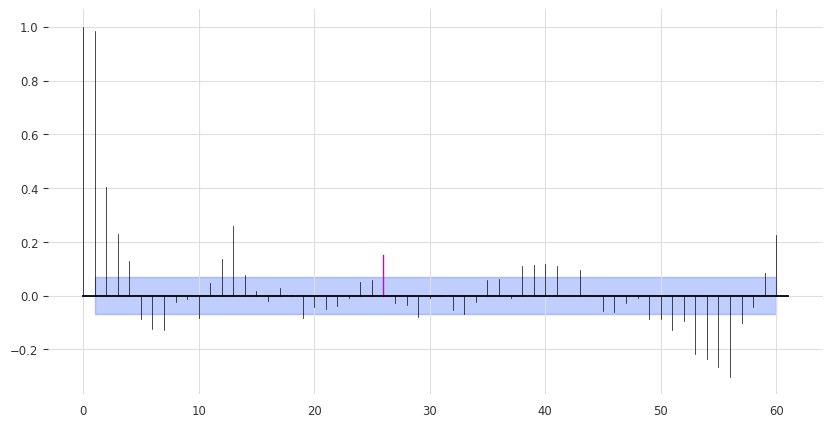

In [8]:
from darts.utils.statistics import plot_acf, check_seasonality, plot_pacf

plot_pacf(median_train['San Francisco'],m=26,alpha=0.05,max_lag=60)
for m in range(2, 104):
    is_seasonal, period = check_seasonality(median_train['San Francisco'], m=m, alpha=0.05,max_lag=104)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

<Axes: xlabel='Date'>

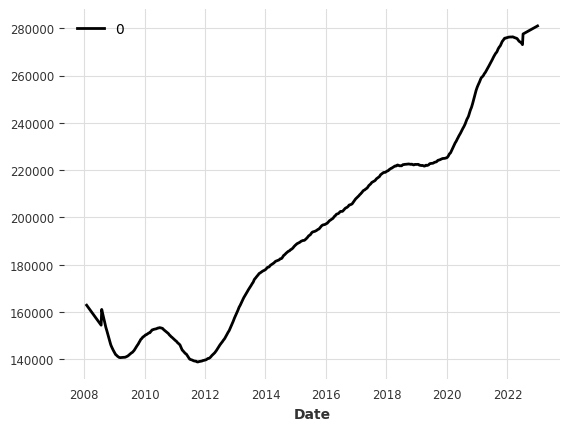

In [9]:
from darts.utils.statistics import extract_trend_and_seasonality
from darts.utils.utils import ModelMode

extract_trend_and_seasonality(median_train['San Diego'],model= ModelMode.MULTIPLICATIVE)[0].plot()

<Axes: xlabel='Date'>

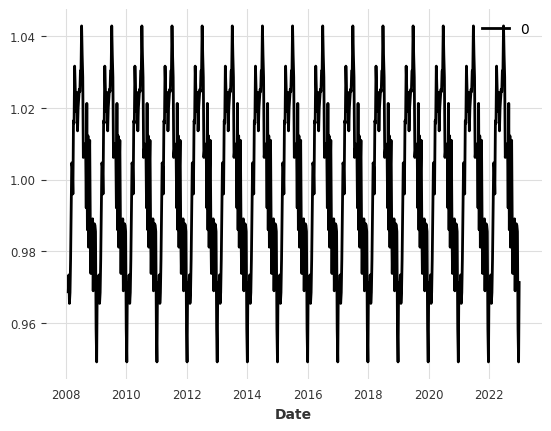

In [10]:
extract_trend_and_seasonality(median_train['San Diego'],model= ModelMode.MULTIPLICATIVE)[1].plot()

In [11]:
from darts.models import RegressionModel, RandomForest
from sklearn.linear_model import BayesianRidge

model=RandomForest(lags=52,lags_past_covariates=26,output_chunk_length=52)

model.fit(median_train['San Diego'],past_covariates=median_train['CPI'])

preds = model.predict(52)



c:\Users\alebe\miniforge3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Axes: xlabel='Date'>

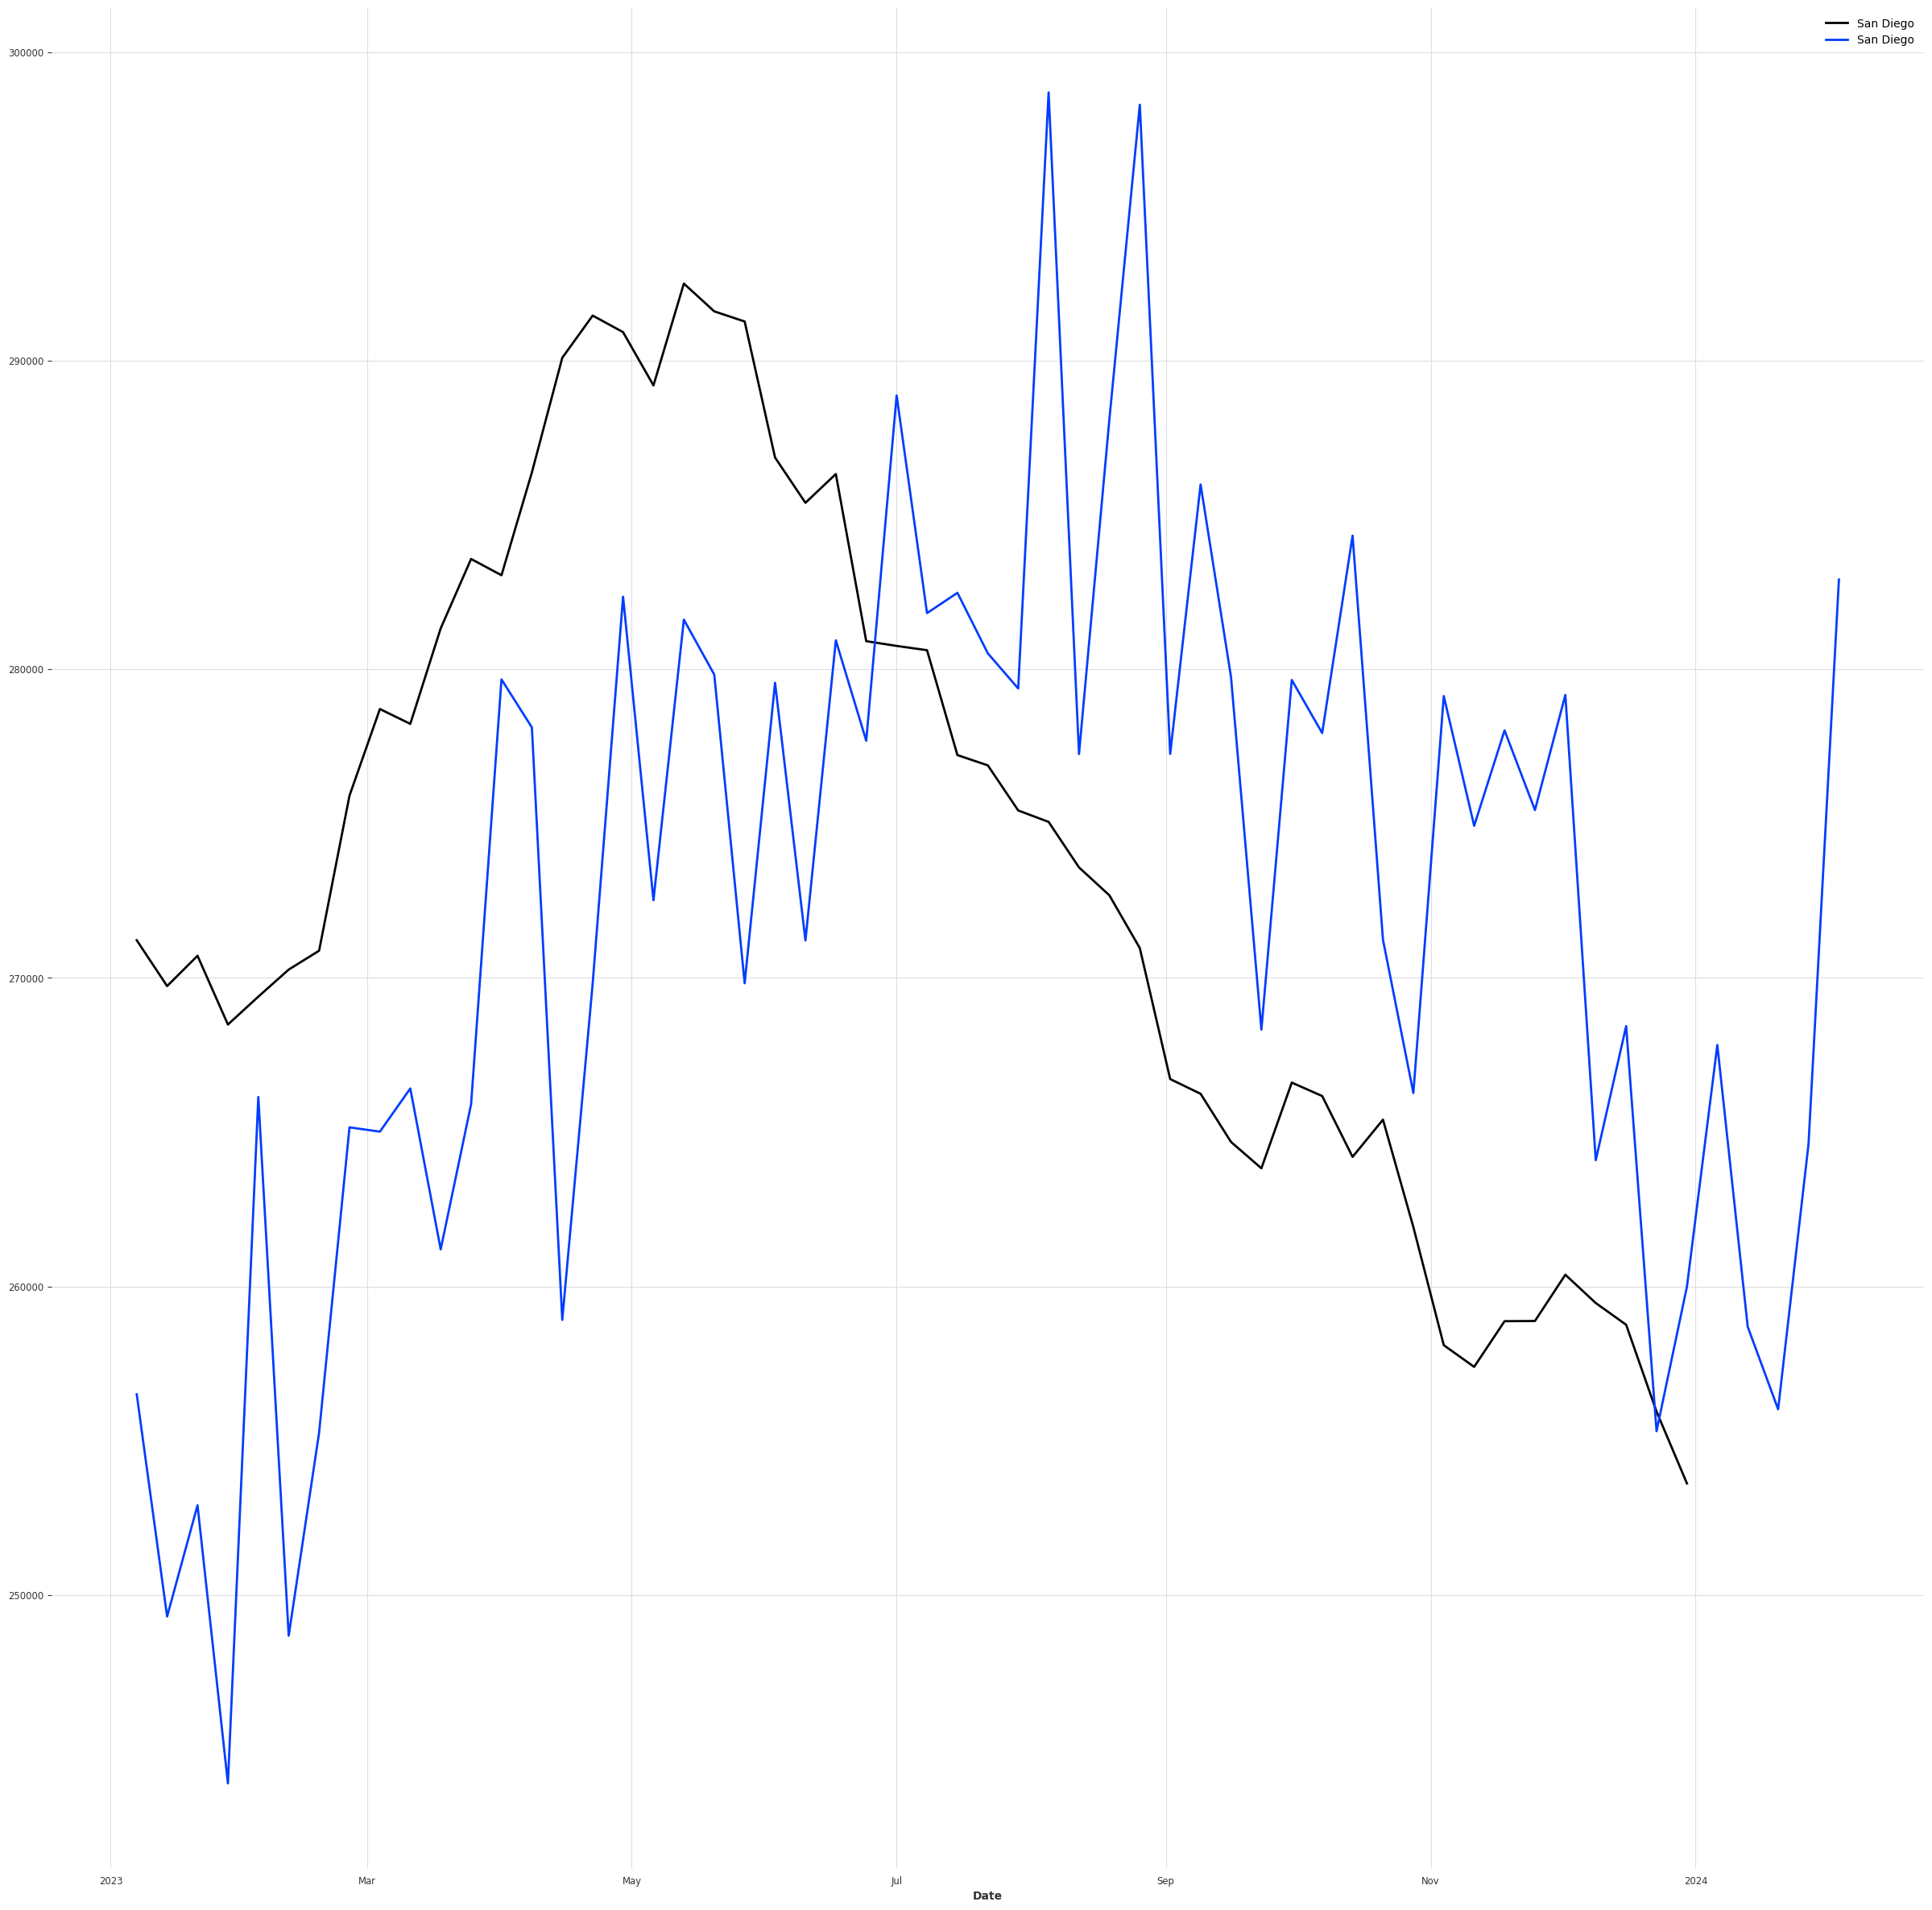

In [12]:
plt.figure(figsize=(30,30))
preds.plot()
median_test['San Diego'].plot()

In [13]:
from darts.models import XGBModel

model2 = XGBModel(lags=52,lags_past_covariates=4,output_chunk_length=60,
                  random_state=42,
                  add_encoders={'cyclic': {'future' : ['month']}})

model2.fit(median_train['San Diego'],past_covariates=median_train['CPI'])

preds = model2.predict(60)



Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


<Axes: xlabel='Date'>

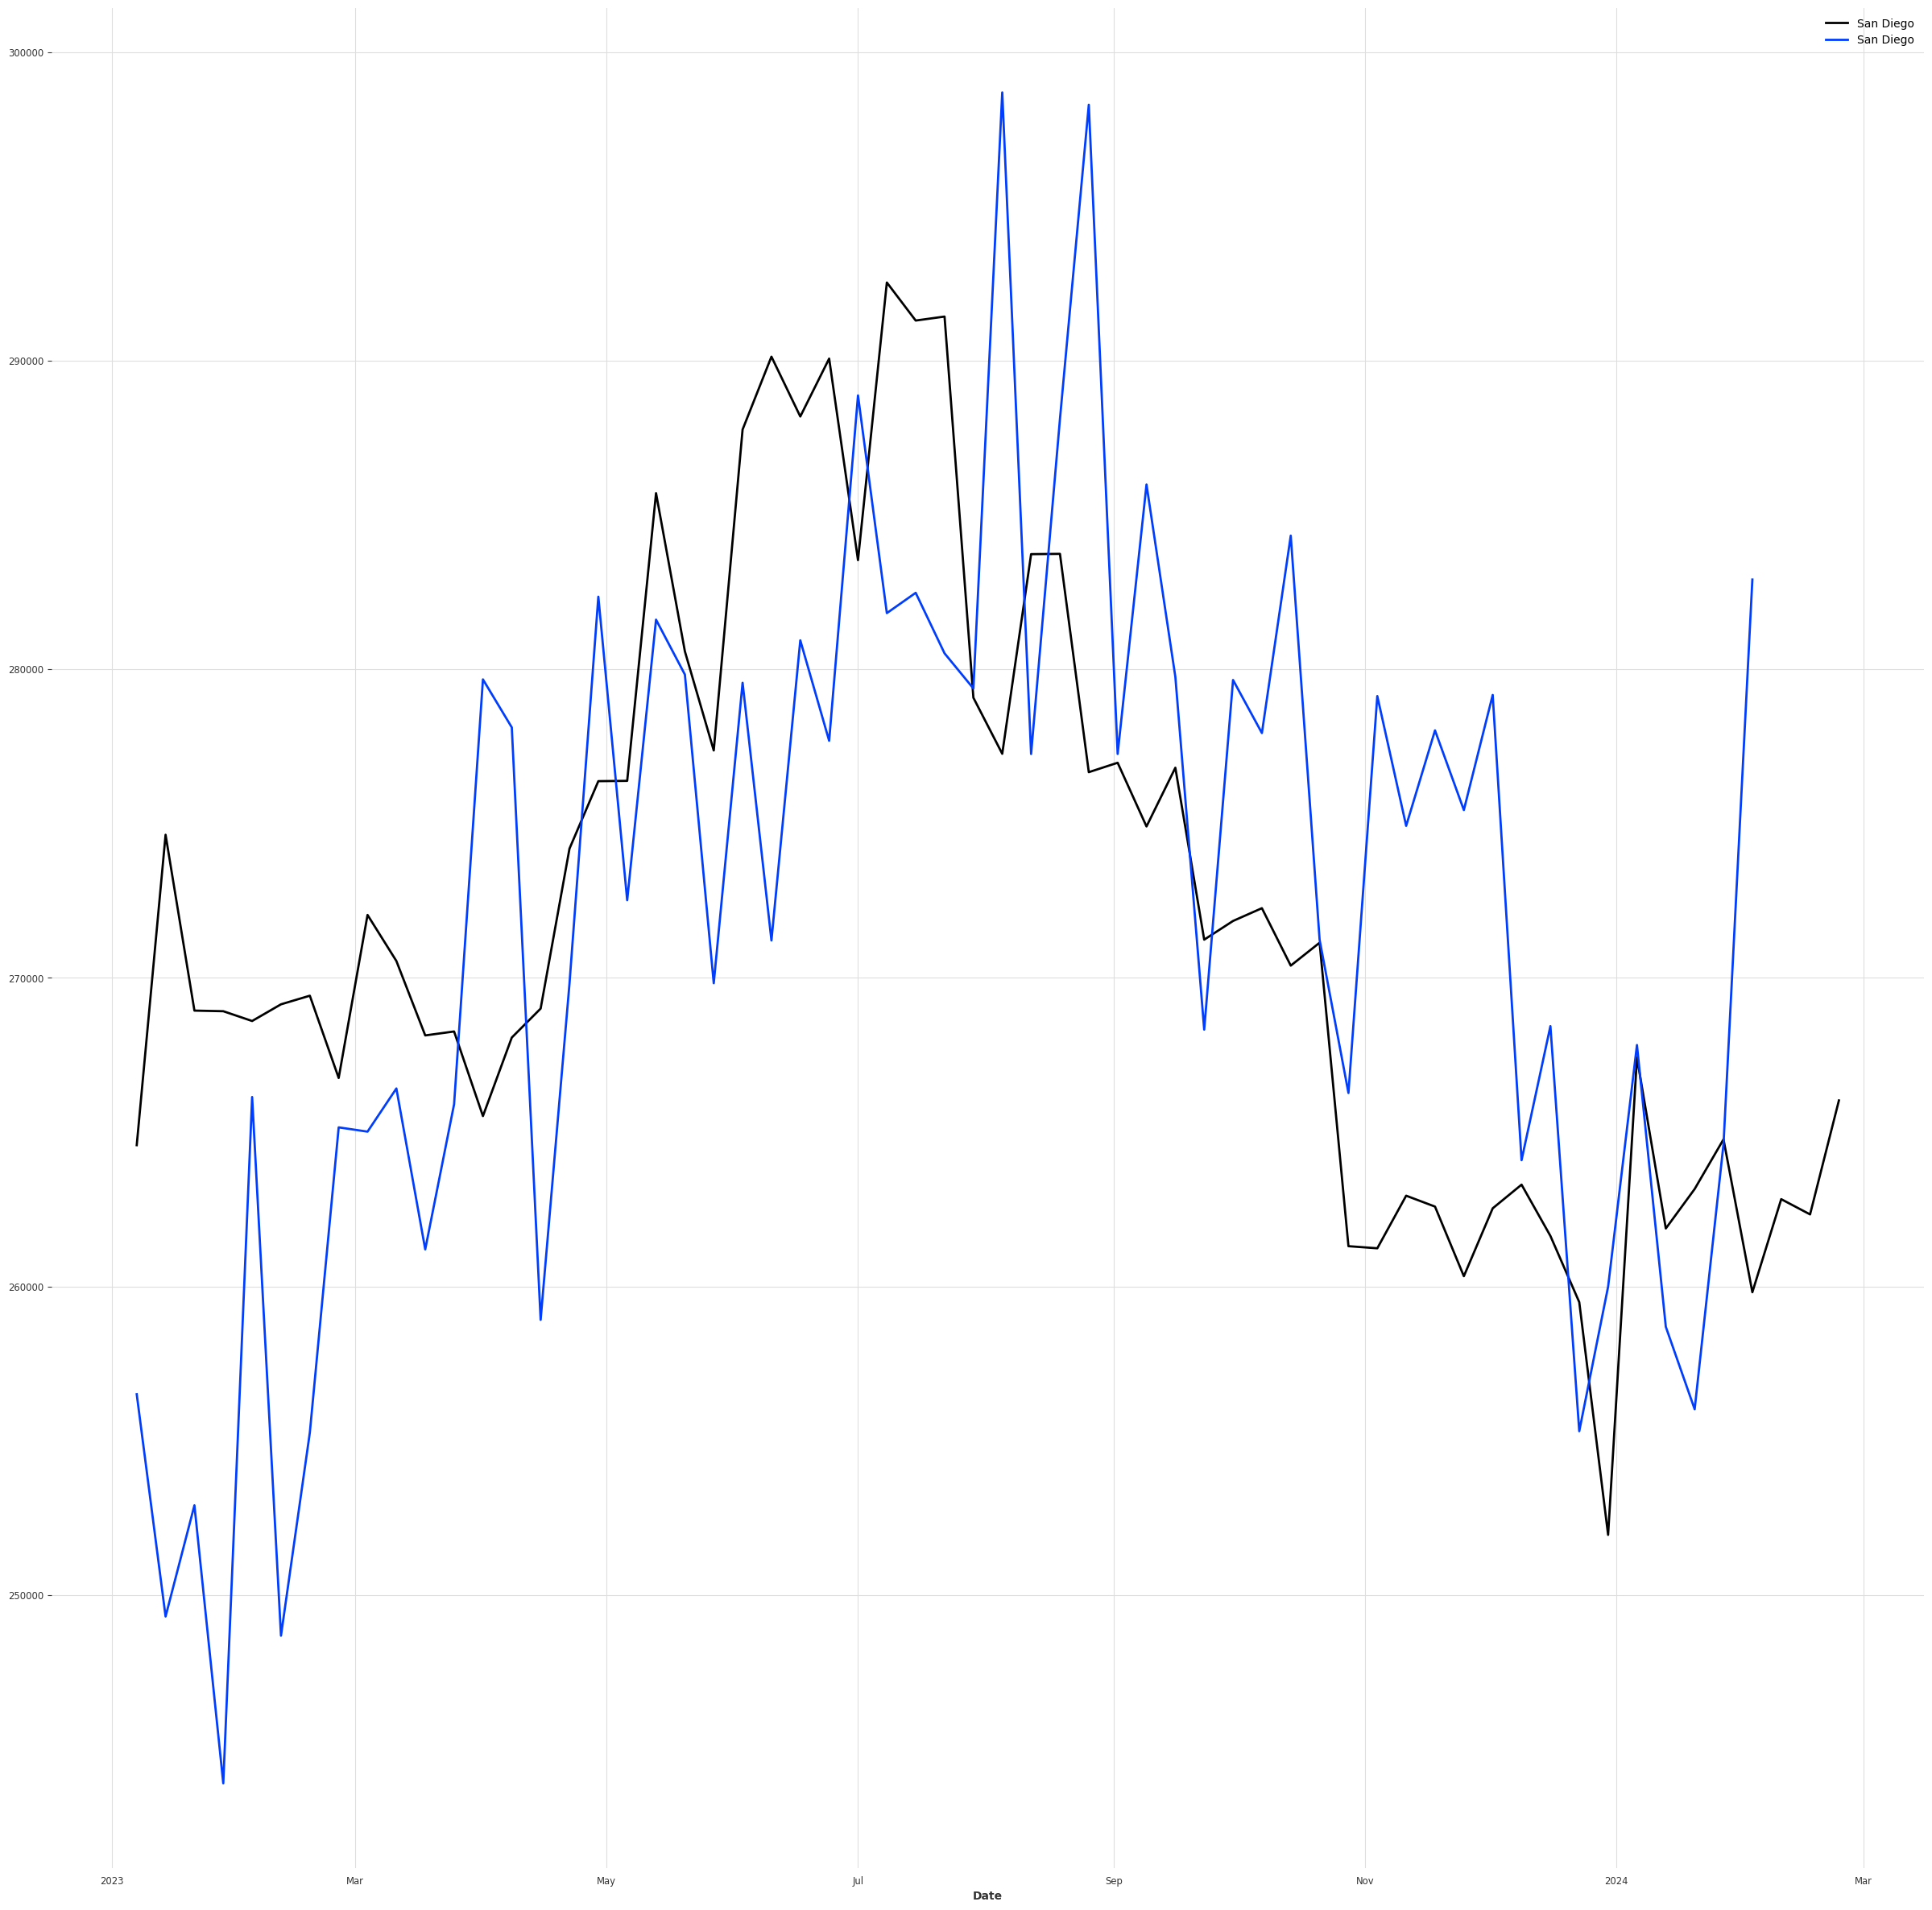

In [14]:
plt.figure(figsize=(30,30))
preds.plot()
median_test['San Diego'].plot()

In [15]:
median_train.columns

Index(['Fresno', 'Los Angeles', 'Merced', 'Riverside', 'Sacramento',
       'San Diego', 'San Francisco', 'San Luis Obispo', 'CPI'],
      dtype='object', name='component')

In [16]:
from darts.metrics import rmse

test = [[26,4],[26,8],[26,12],[26,16],[26,20],[26,24],[52,4],[52,8],[52,12],[52,16],[52,20],
        [52,24],[60,4],[60,8],[60,12],[60,16],[60,20],[60,24]]
names = median_train.columns

results = {}

for i in test:
    avg_rmse = []
    modl = XGBModel(lags=i[0],lags_past_covariates=i[1],output_chunk_length=60,
                  random_state=42,
                  add_encoders={'cyclic': {'future' : ['month']}})
    for j in names:

        modl.fit(median_train[j],past_covariates=median_train['CPI'])

        preds = modl.predict(57)

        avg_rmse.append(rmse(median_test[j],preds))

    results[str(i)] = avg_rmse

results

Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
Specified future enc

{'[26, 4]': [9124.333585915194,
  15717.584939337888,
  21520.43668060748,
  10411.701773755845,
  10795.514491118249,
  11191.312569213063,
  38298.404588792495,
  32334.778395269102,
  14.568067838484815],
 '[26, 8]': [9157.342674203444,
  15489.009716425253,
  21724.84003875152,
  10534.705390539406,
  11384.37331594953,
  11530.403022741657,
  38351.05650052723,
  31646.034471216124,
  14.568067838484815],
 '[26, 12]': [8630.070226592066,
  14822.839808268587,
  21028.732192889478,
  10609.87481424636,
  11861.073738843037,
  11244.408058938961,
  36685.3083544579,
  32831.239063014385,
  14.568067838484815],
 '[26, 16]': [8565.507100451508,
  14935.98531280069,
  21468.88229177327,
  10683.99208325329,
  13217.76251451713,
  11633.6113703461,
  37463.76065434941,
  32221.118455069234,
  14.568067838484815],
 '[26, 20]': [8985.354232700043,
  14411.340095288146,
  21447.663051984156,
  10473.443933773397,
  13327.165906102857,
  11410.881497069937,
  37854.45551409719,
  32879.5391

In [17]:
rmses = {}
for i in results.keys():
    rmses[i] = np.mean(results[i])

rmses

{'[26, 4]': 16600.959454649754,
 '[26, 8]': 16648.037022021406,
 '[26, 12]': 16414.234925009918,
 '[26, 16]': 16689.465316711012,
 '[26, 20]': 16756.045717246,
 '[26, 24]': 16726.75521381567,
 '[52, 4]': 16239.294678745779,
 '[52, 8]': 16688.61061889316,
 '[52, 12]': 16892.015957866693,
 '[52, 16]': 16965.5606565277,
 '[52, 20]': 16698.568570304633,
 '[52, 24]': 16688.357118684213,
 '[60, 4]': 16372.705269532038,
 '[60, 8]': 16637.225320556427,
 '[60, 12]': 17055.92182620276,
 '[60, 16]': 16656.822412863952,
 '[60, 20]': 17032.10479768792,
 '[60, 24]': 16950.950277572472}

In [18]:

xgmodel = XGBModel(lags=52,lags_past_covariates=4,output_chunk_length=60,
                  random_state=42,
                  add_encoders={'cyclic': {'past' : ['month'],'future' : ['month']},
                                'datetime_attribute' : {'past':['month','year'],'future':['month','year']}})

xgmodel.fit(median_train['San Francisco'],past_covariates=median_train['CPI'])

preds = xgmodel.predict(n=60)

Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


<Axes: xlabel='Date'>

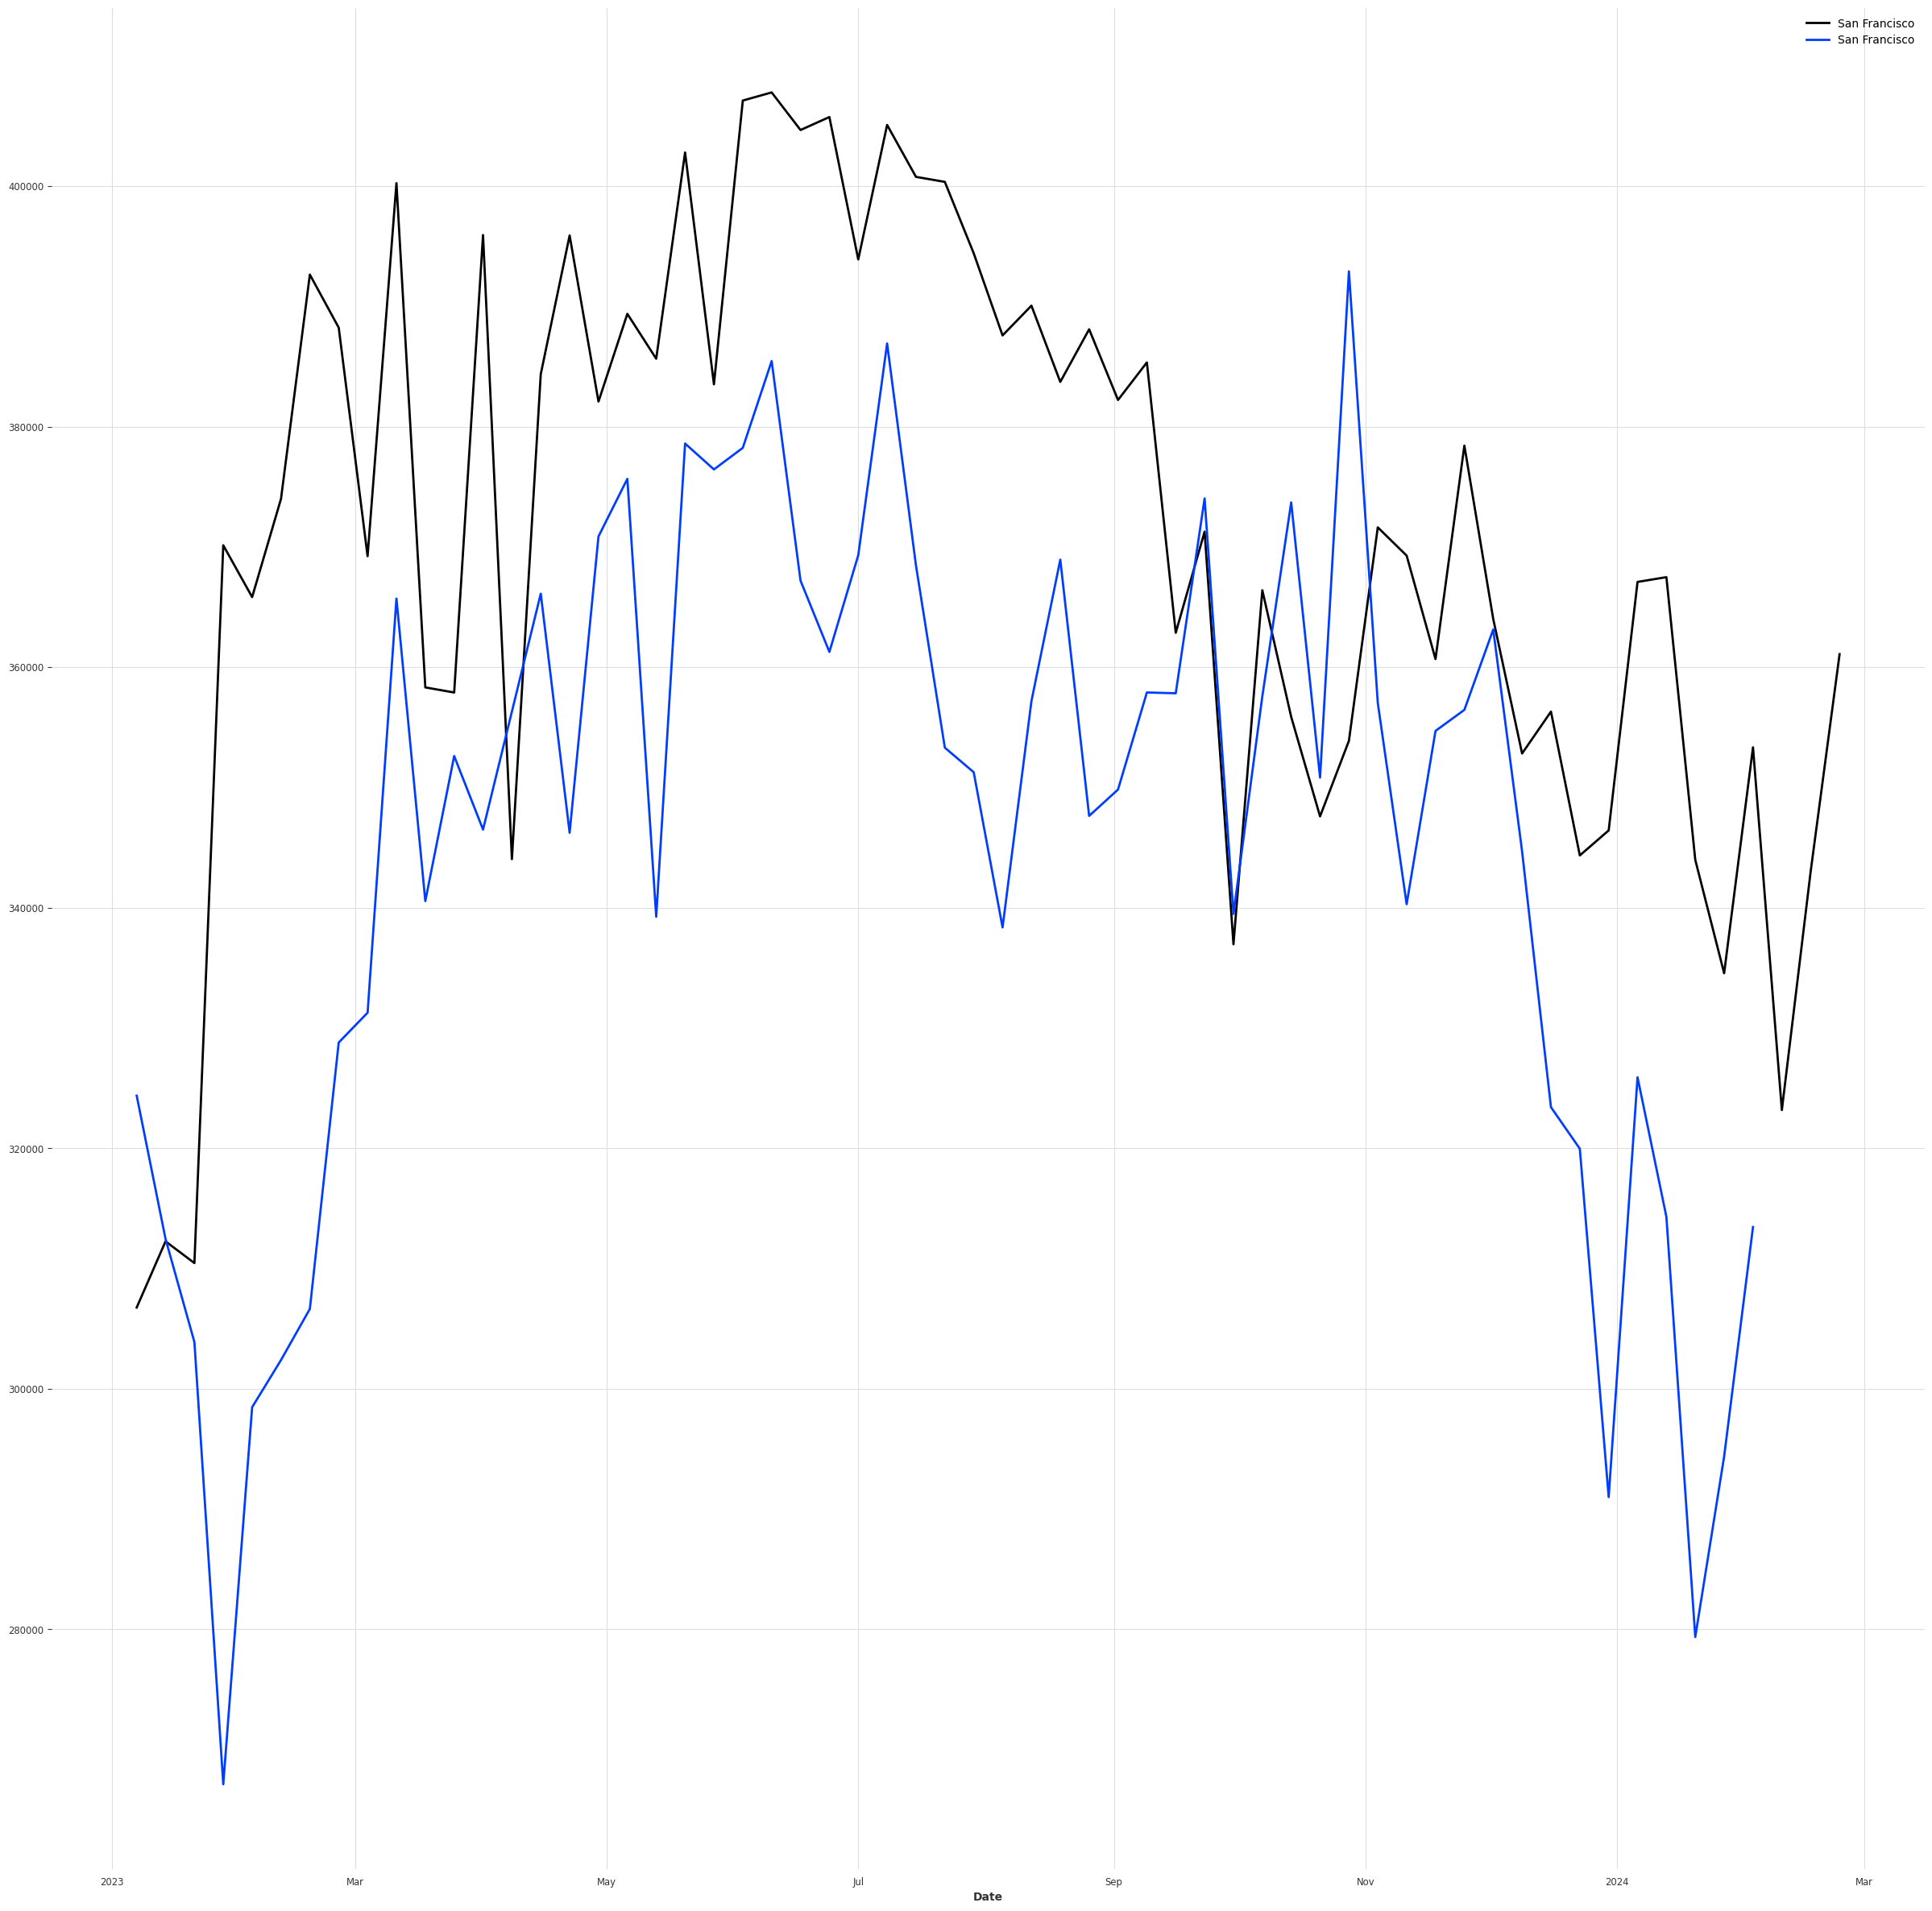

In [19]:
plt.figure(figsize=(30,30))
preds.plot()
median_test['San Francisco'].plot()

In [20]:
xgmodel2 = XGBModel(lags=26,lags_past_covariates=4,output_chunk_length=60,
                  random_state=42,
                  add_encoders={'cyclic': {'future' : ['month']}})

xgmodel2.fit(median_train.drop_columns('CPI'),past_covariates=median_train['CPI'])

preds = xgmodel2.predict(n=60)

Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


<Axes: xlabel='Date'>

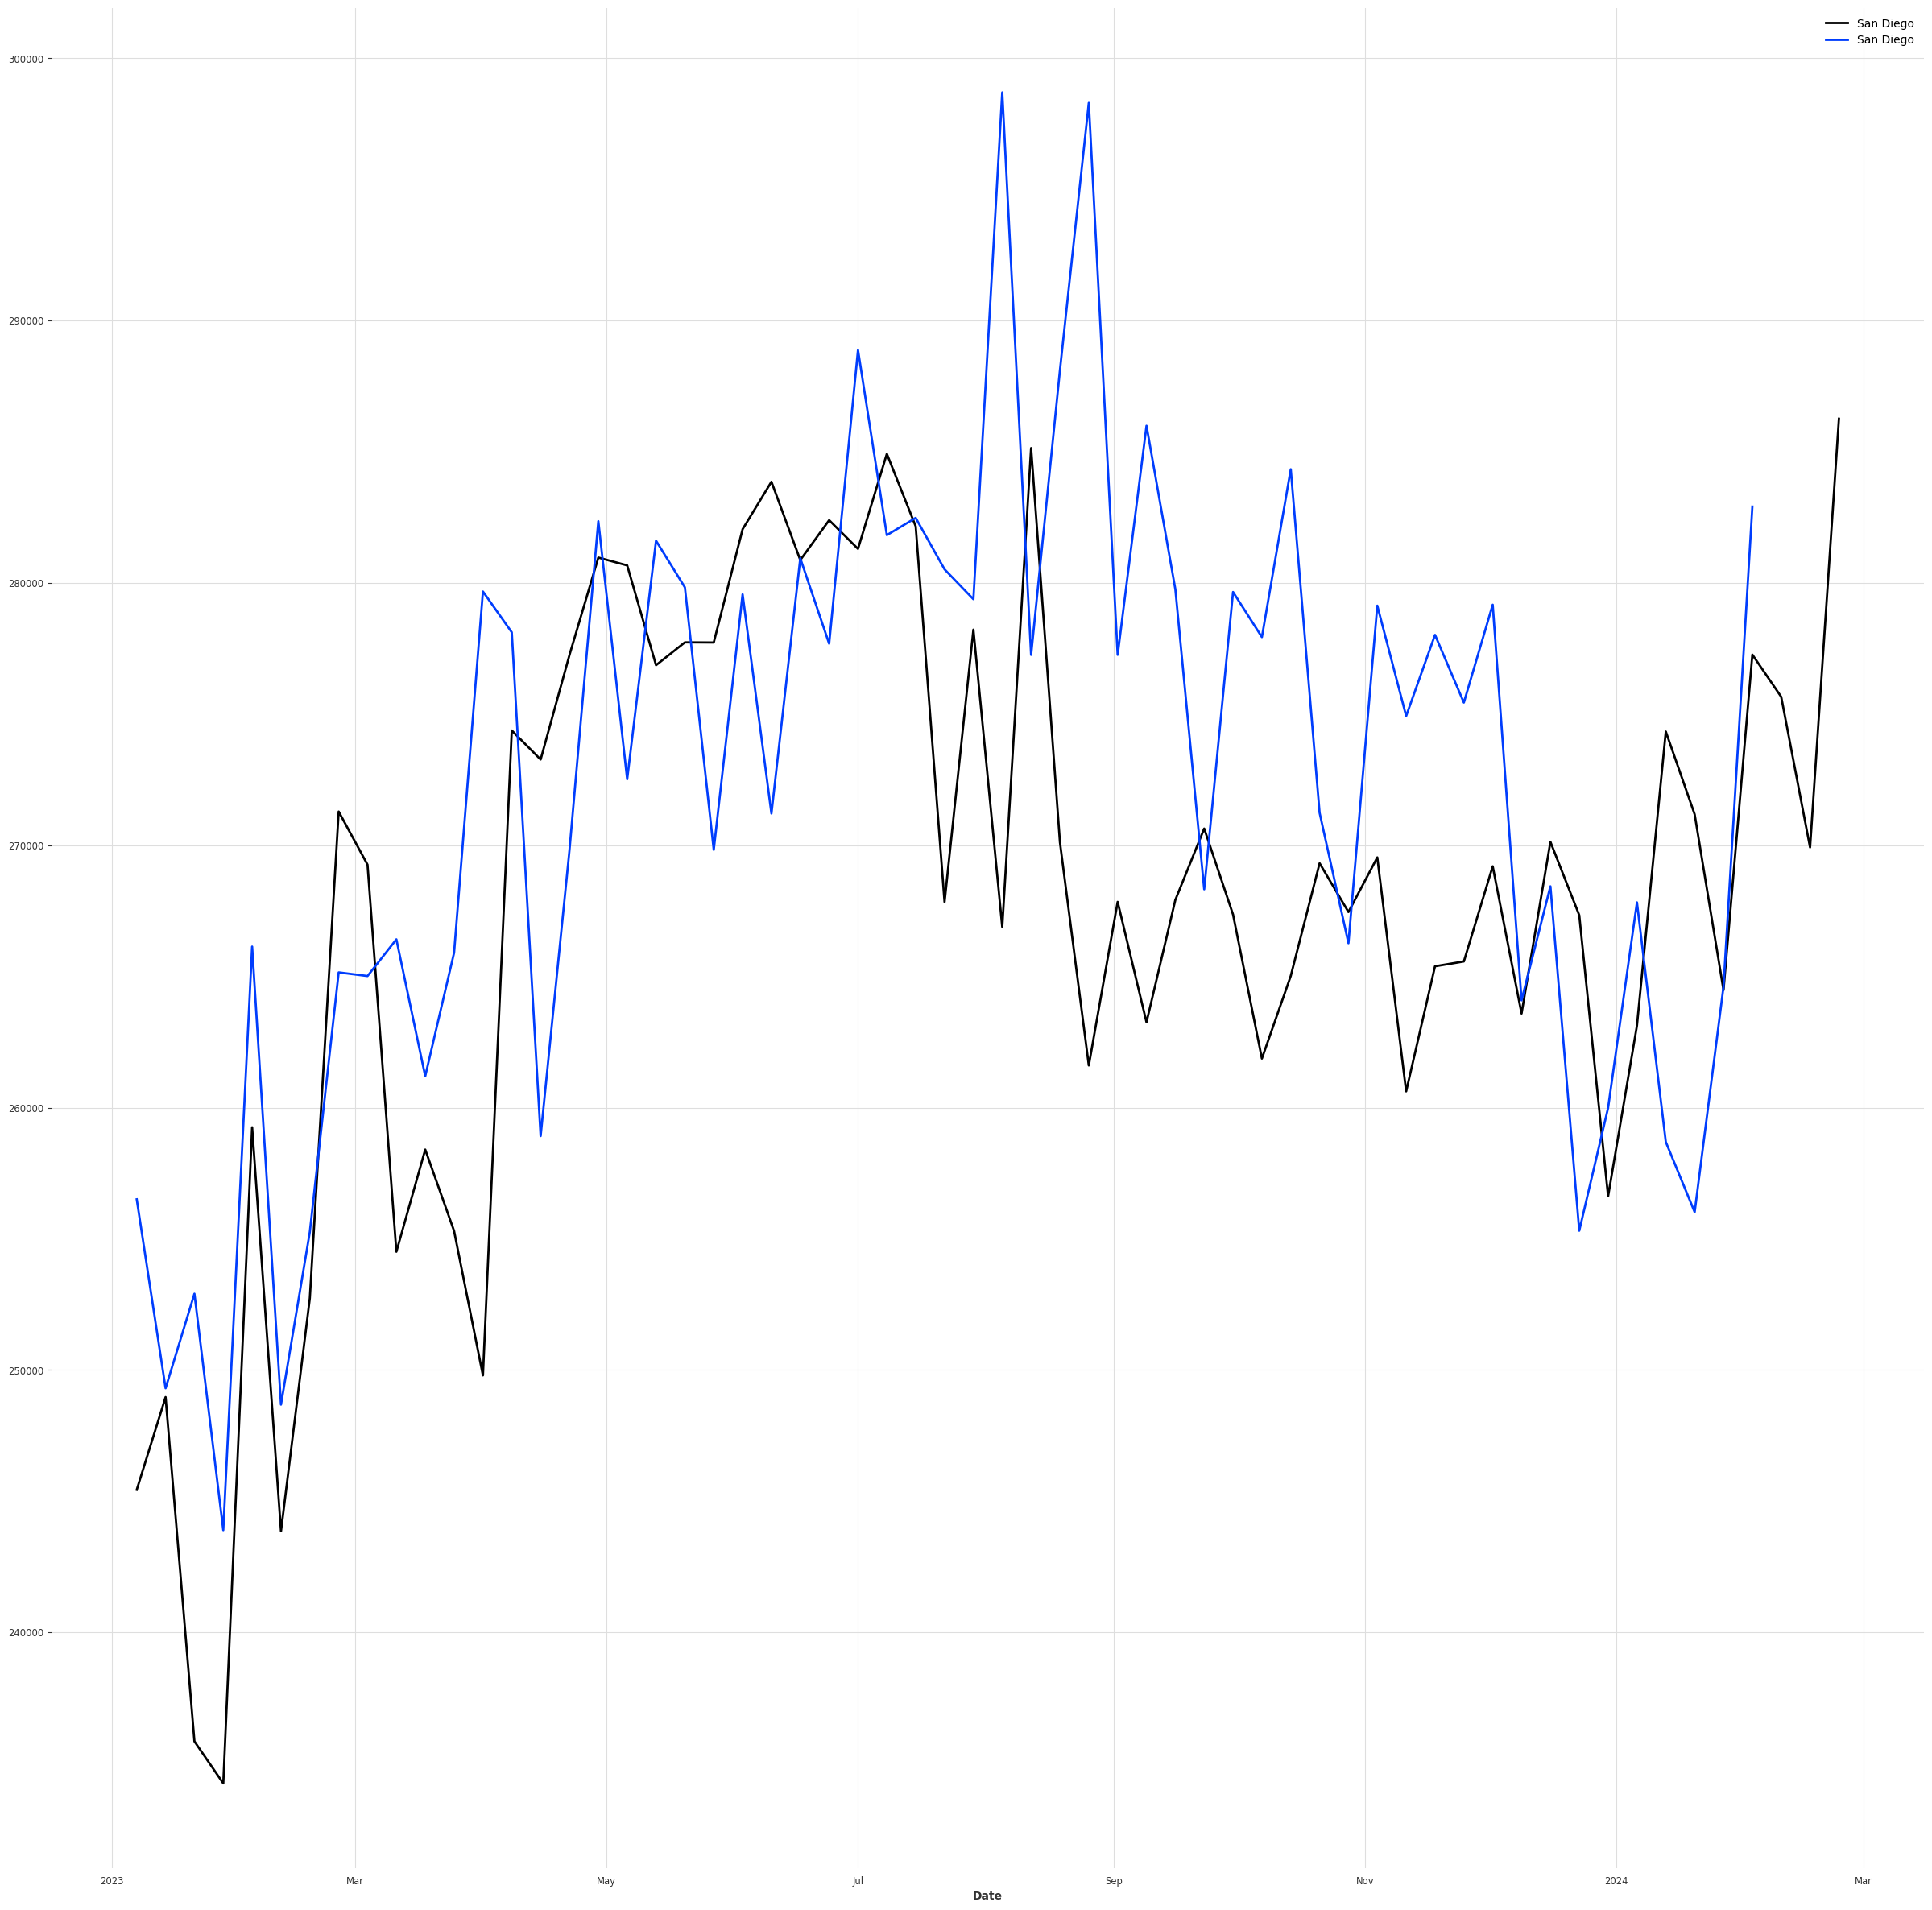

In [21]:
plt.figure(figsize=(30,30))
preds['San Diego'].plot()
median_test['San Diego'].plot()

<Axes: xlabel='Date'>

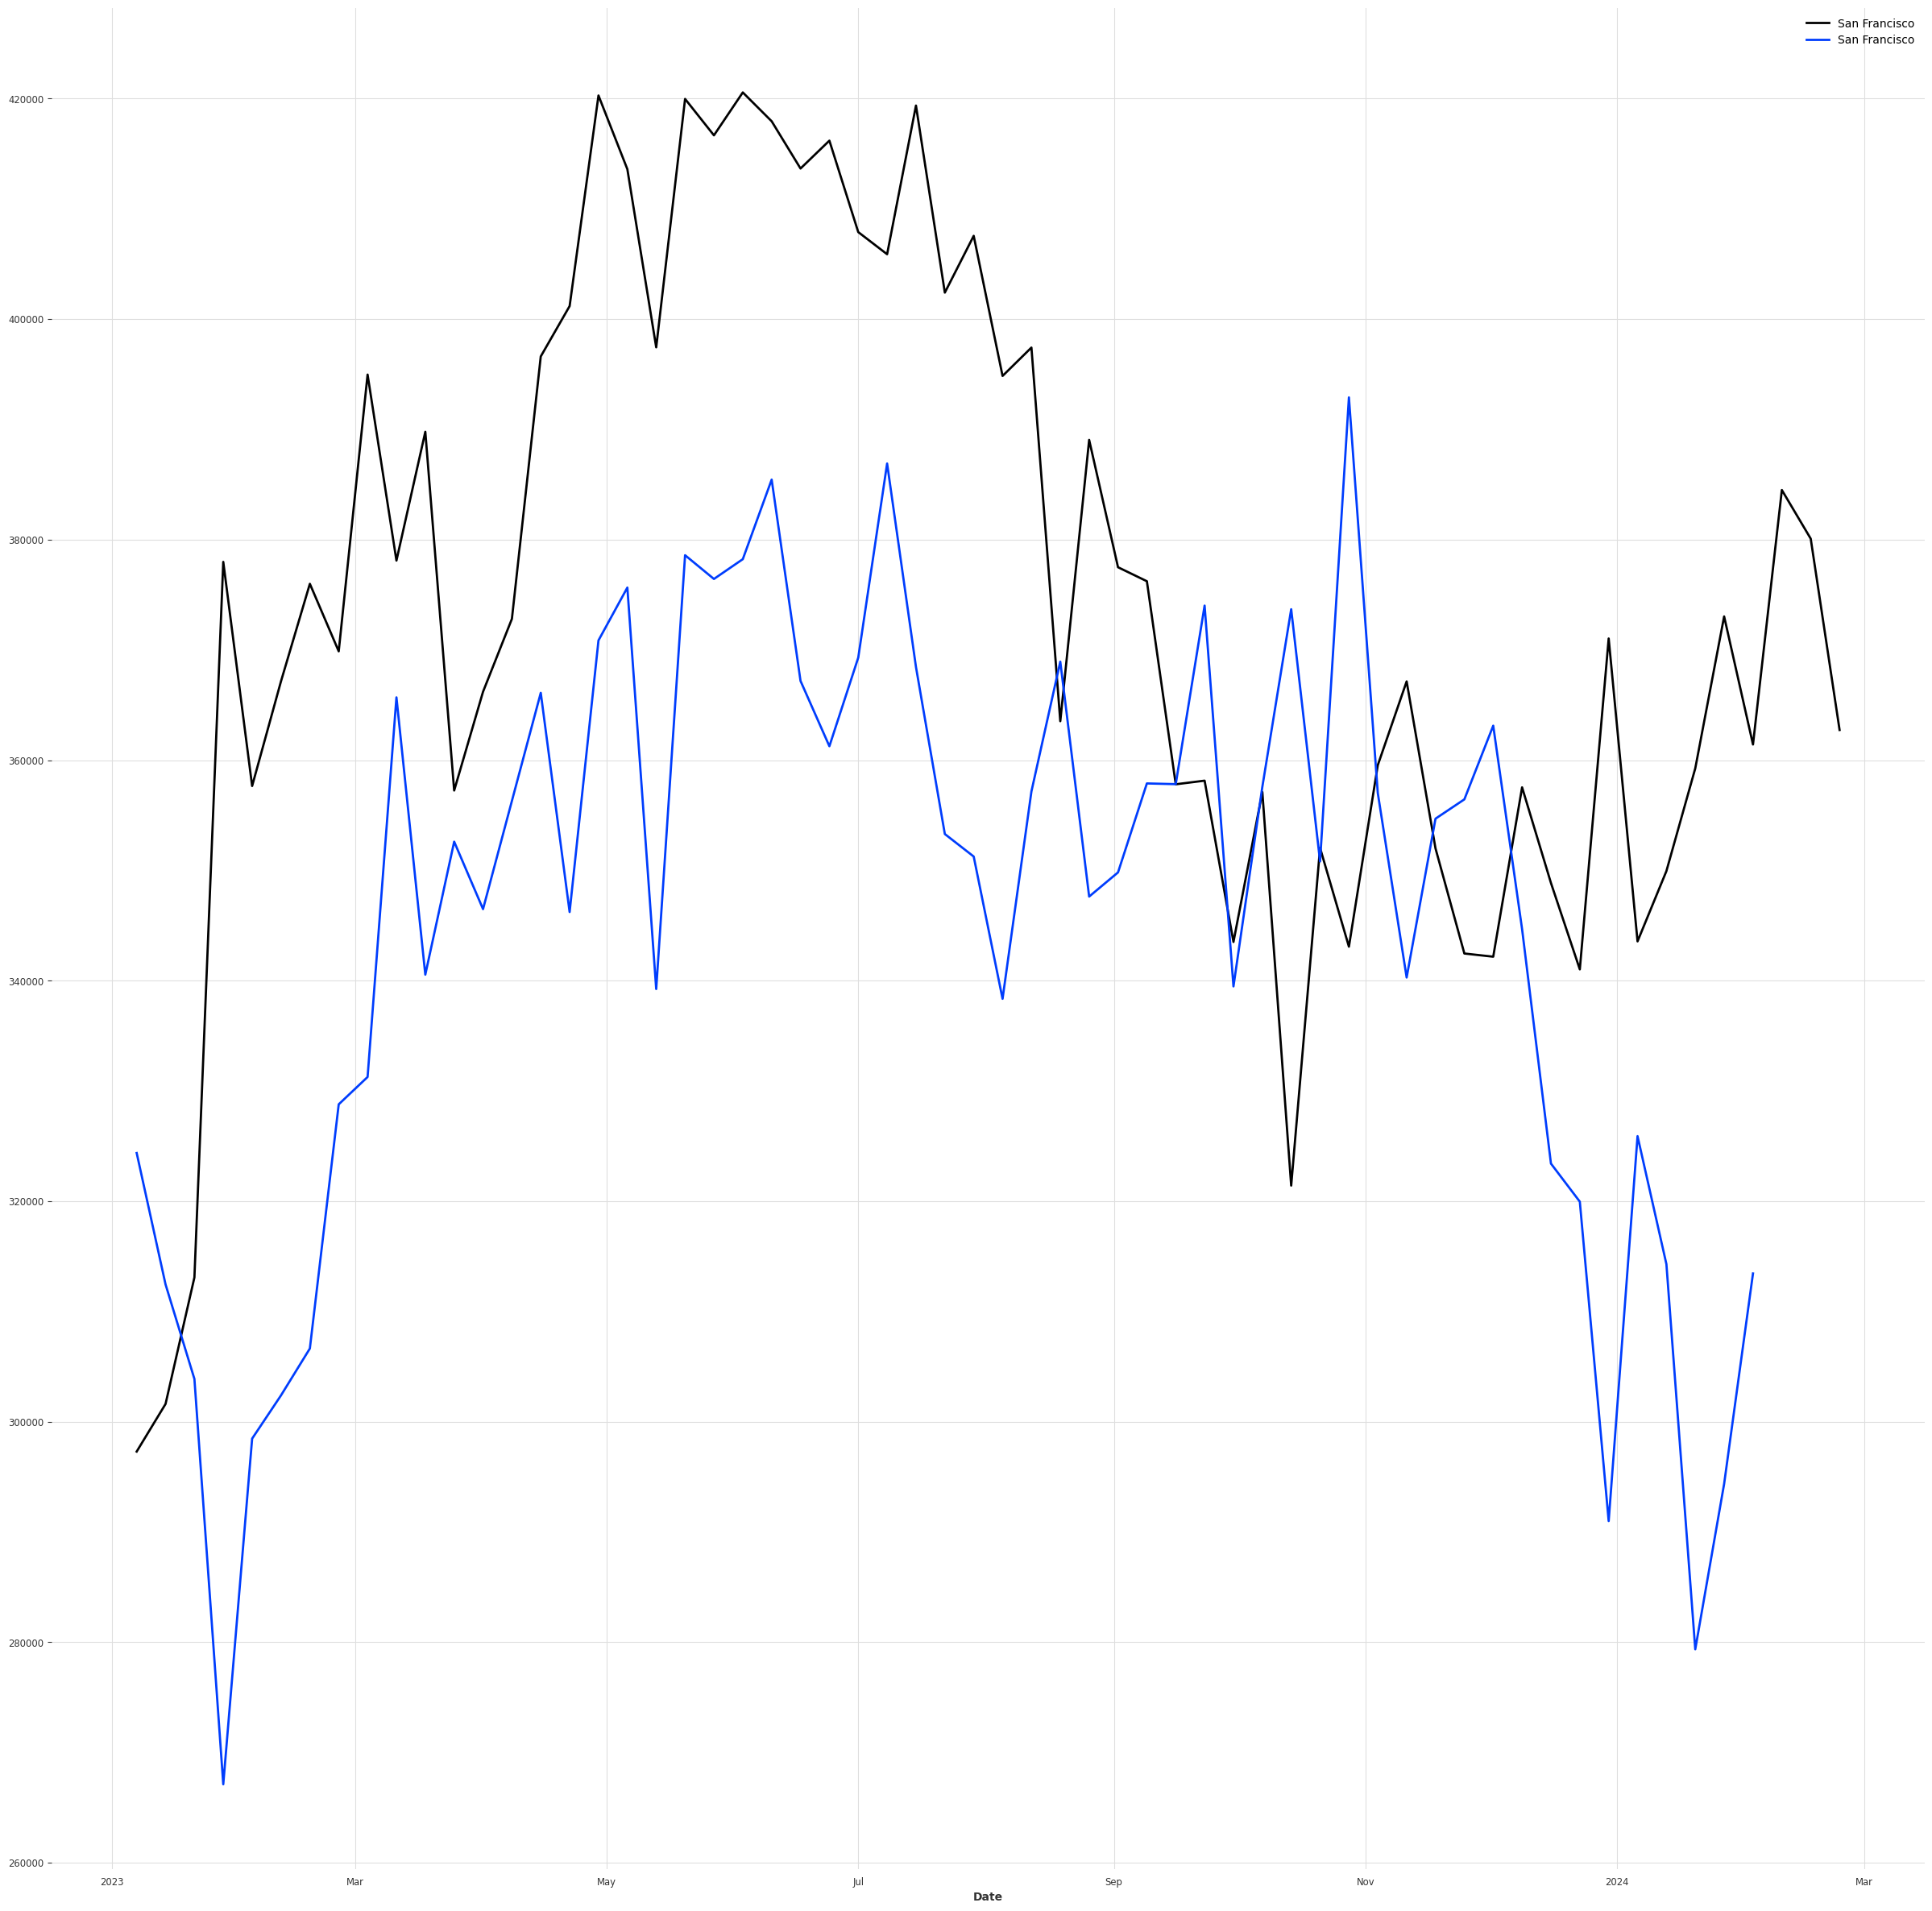

In [22]:
plt.figure(figsize=(30,30))
preds['San Francisco'].plot()
median_test['San Francisco'].plot()

<Axes: xlabel='Date'>

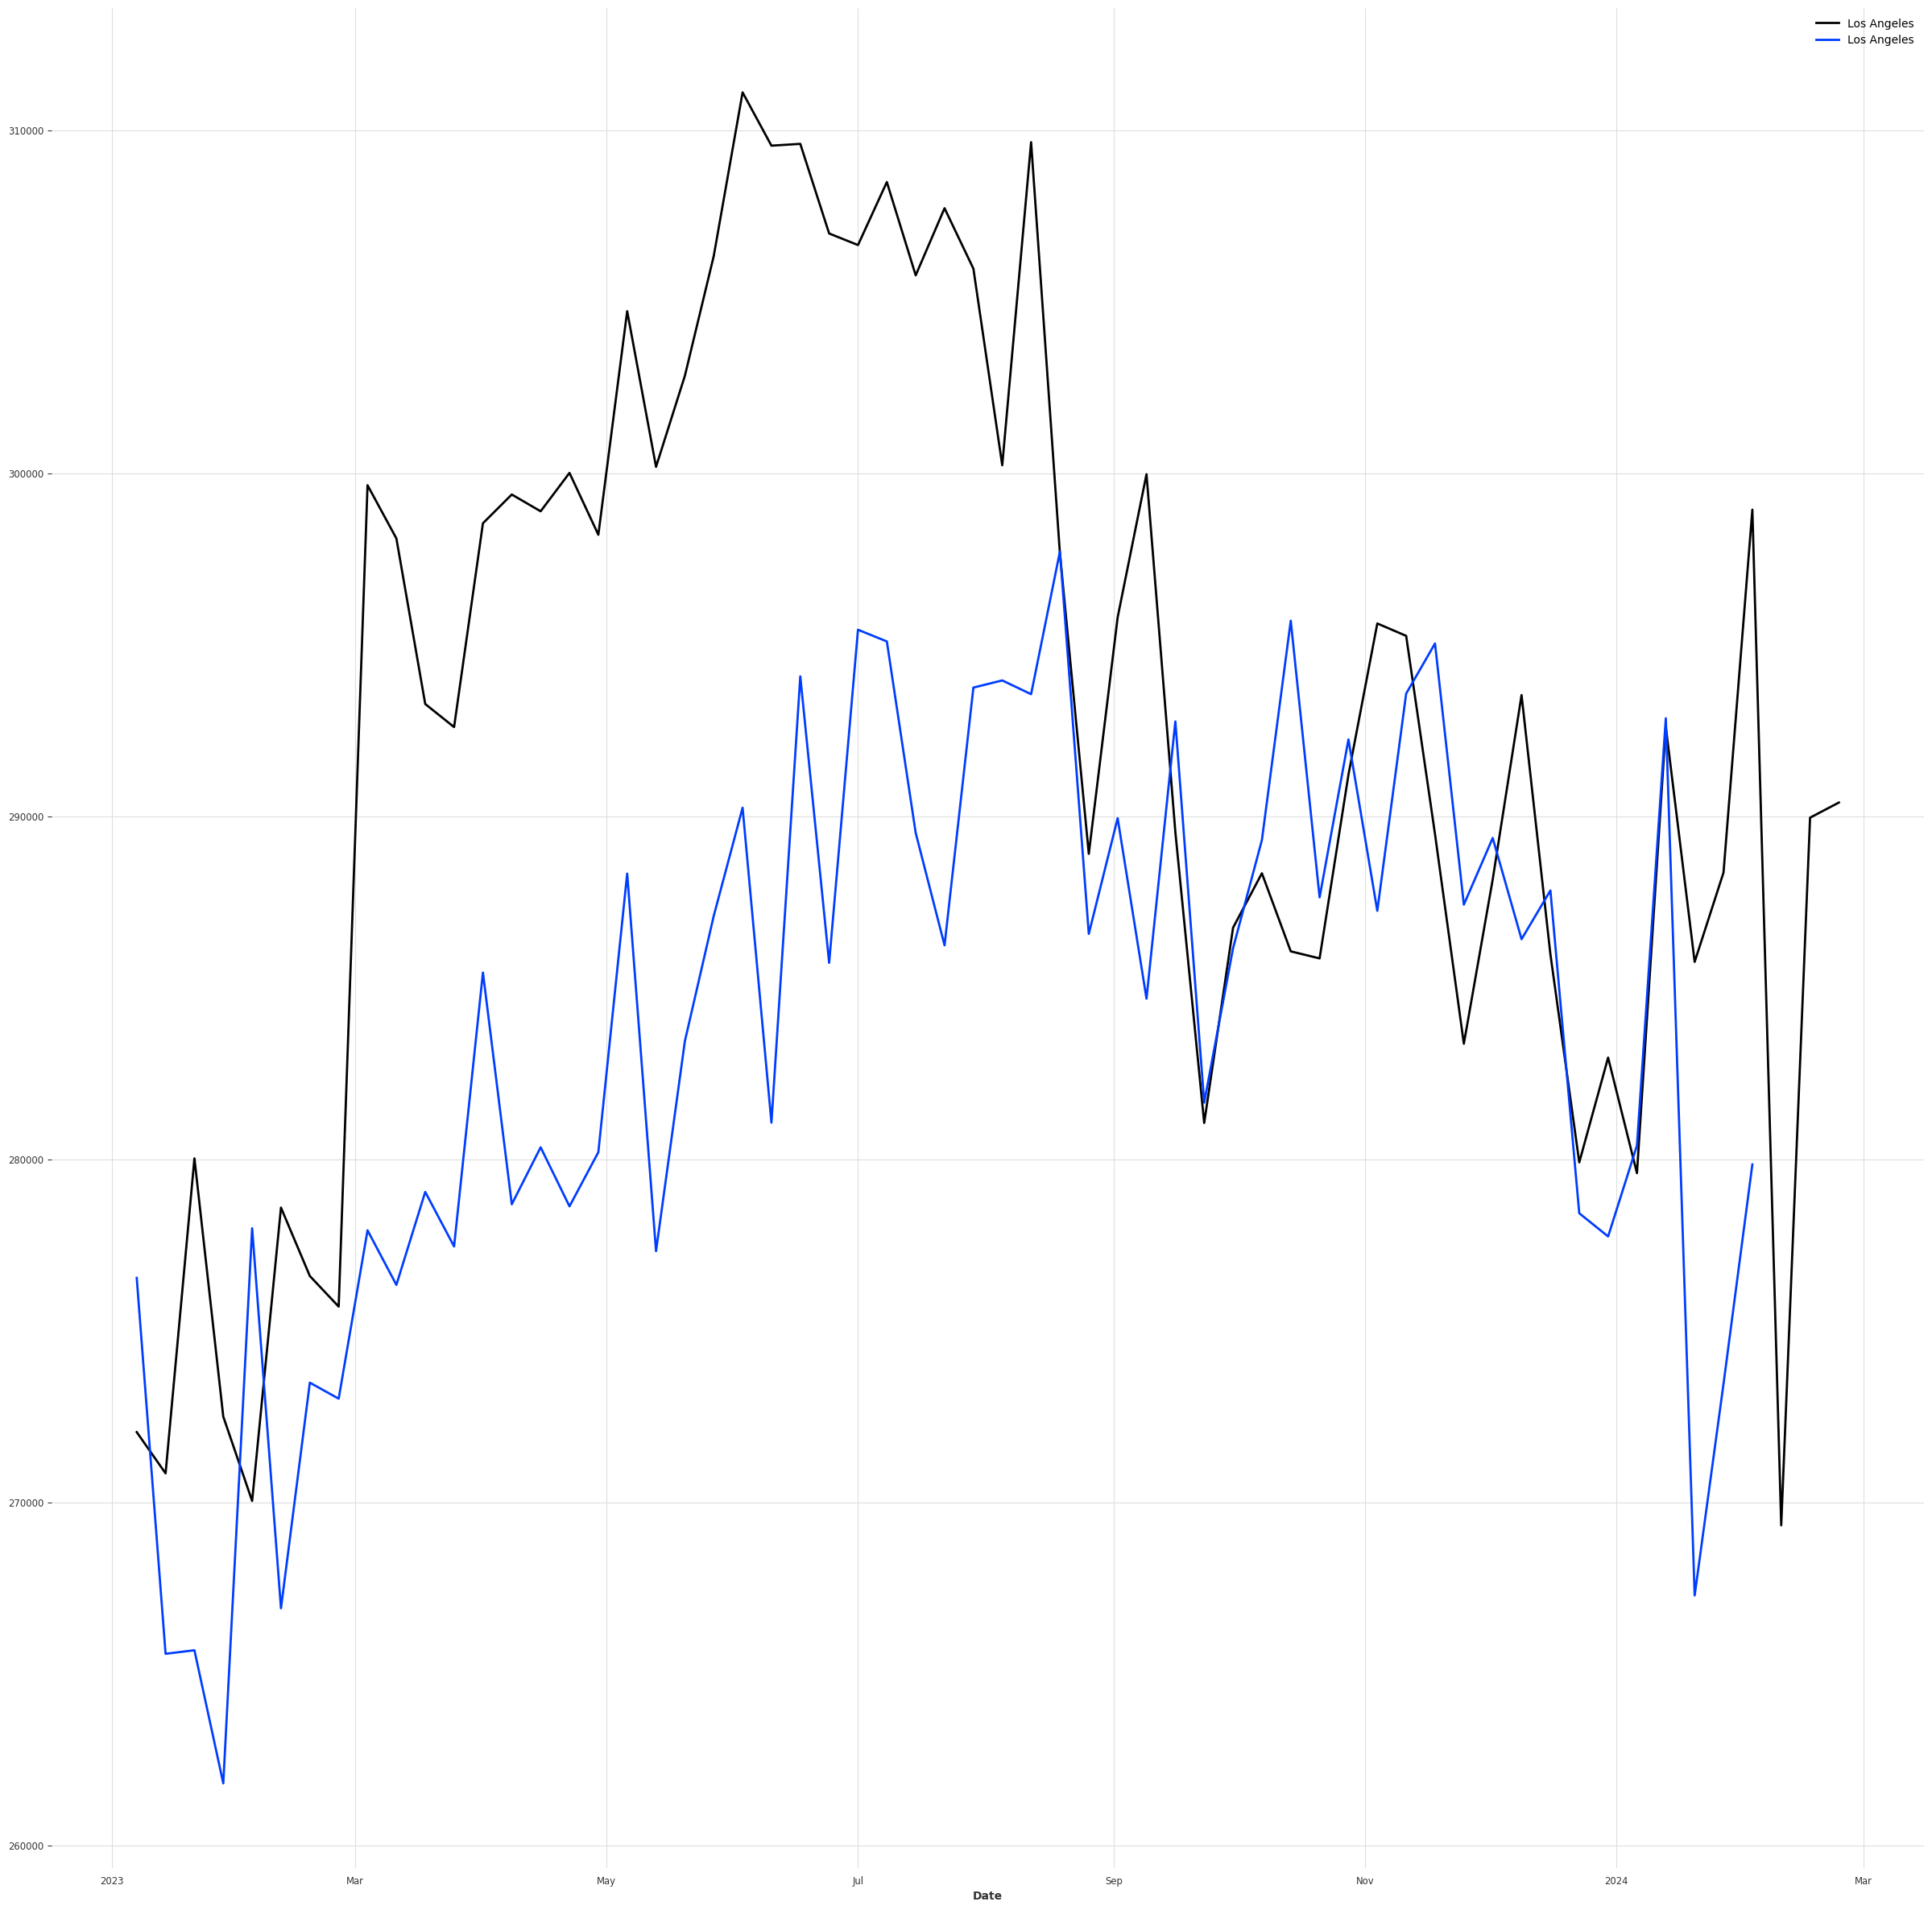

In [23]:
plt.figure(figsize=(30,30))
preds['Los Angeles'].plot()
median_test['Los Angeles'].plot()

<Axes: xlabel='Date'>

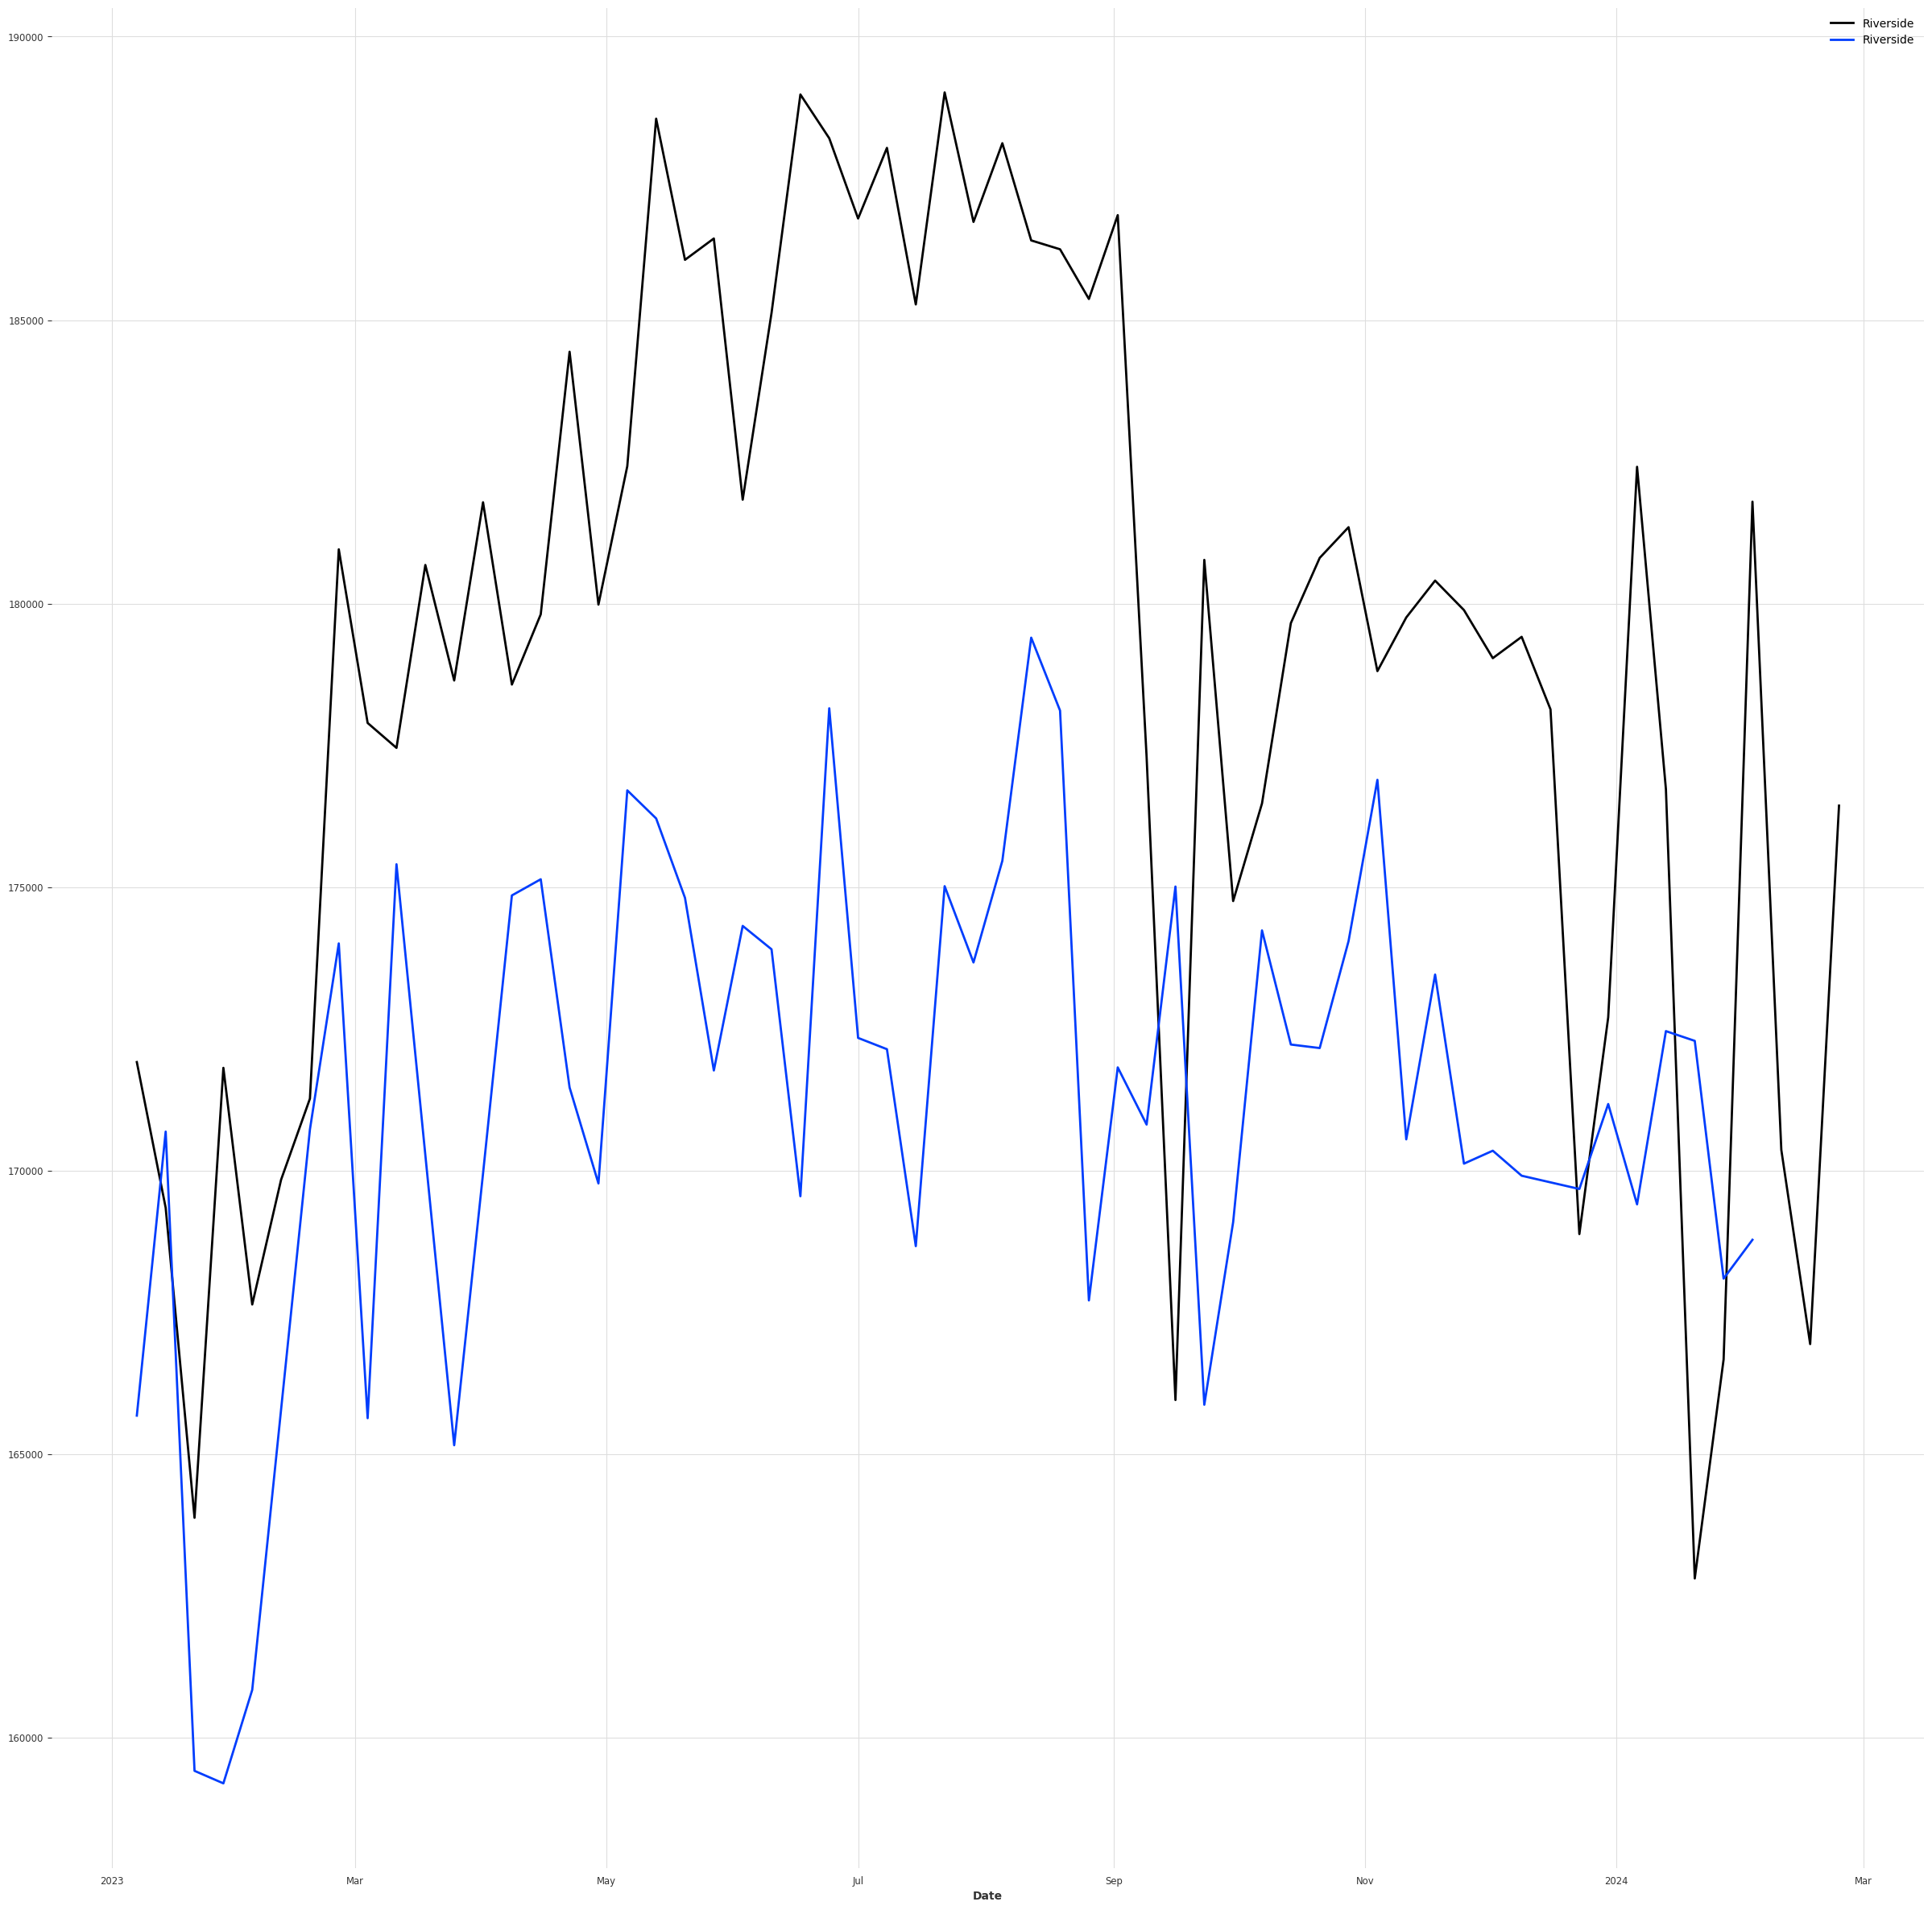

In [24]:
plt.figure(figsize=(30,30))
preds['Riverside'].plot()
median_test['Riverside'].plot()

<Axes: xlabel='Date'>

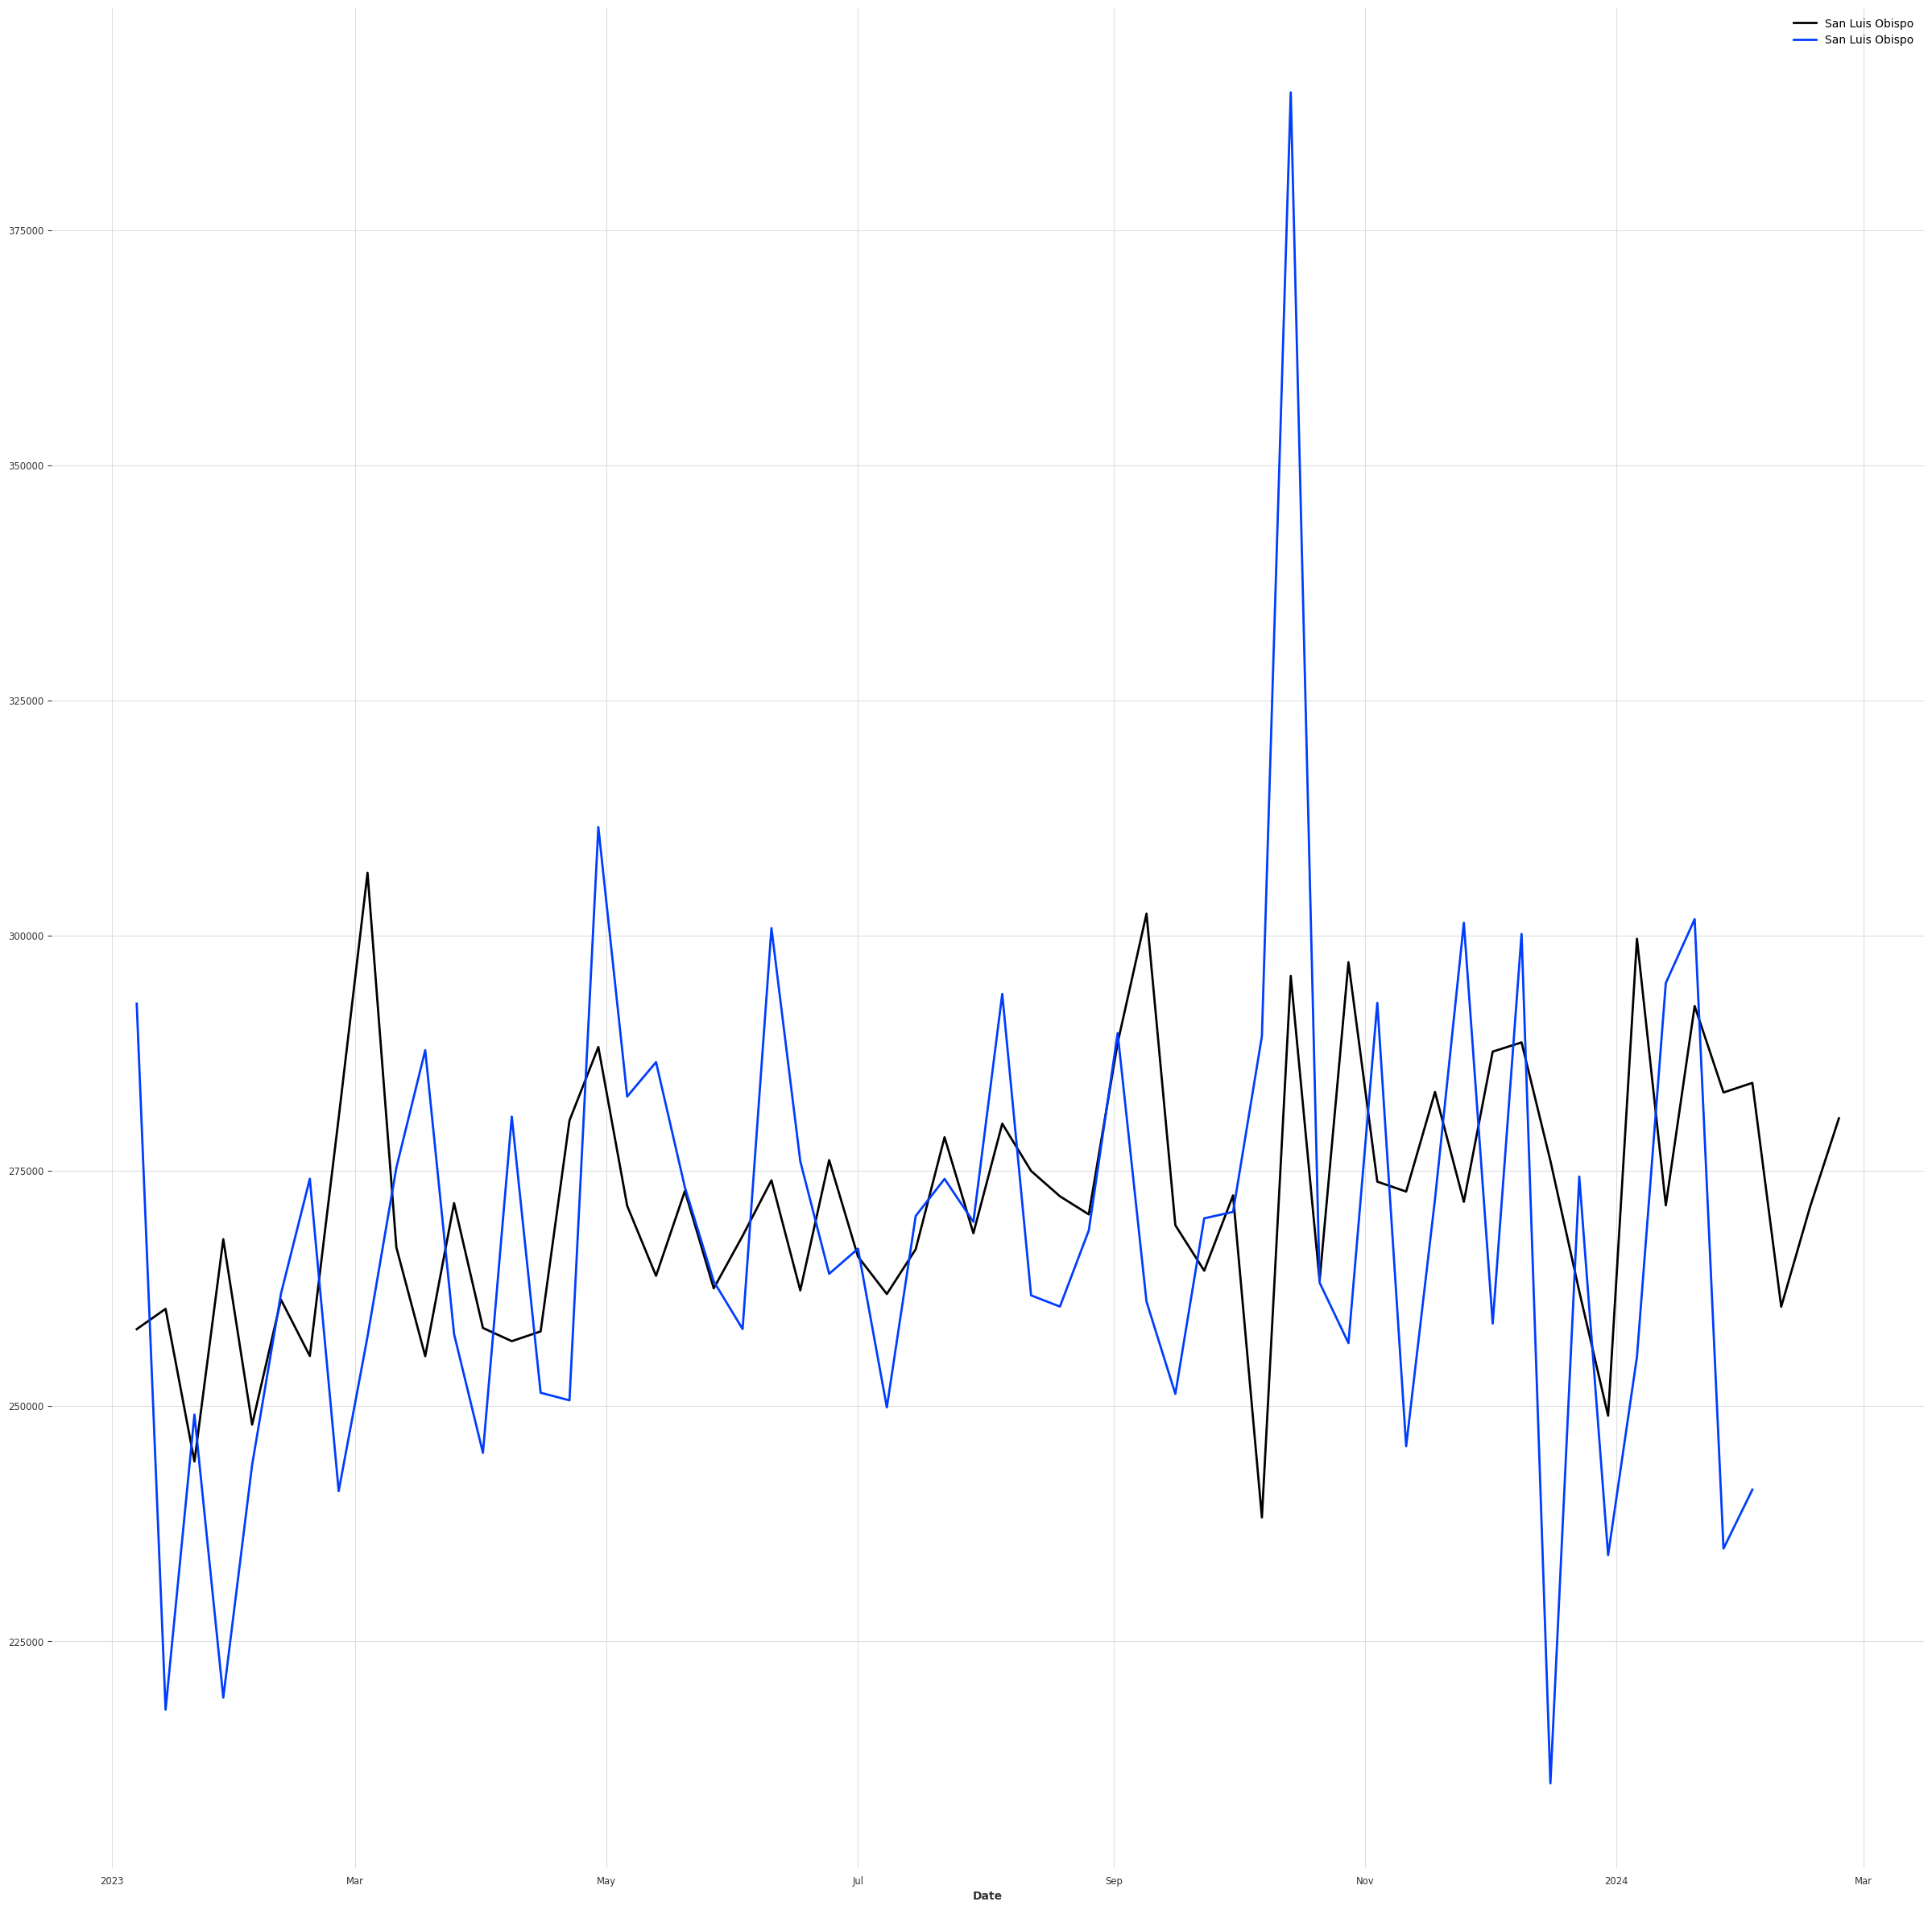

In [25]:
plt.figure(figsize=(30,30))
preds['San Luis Obispo'].plot()
median_test['San Luis Obispo'].plot()

<Axes: xlabel='Date'>

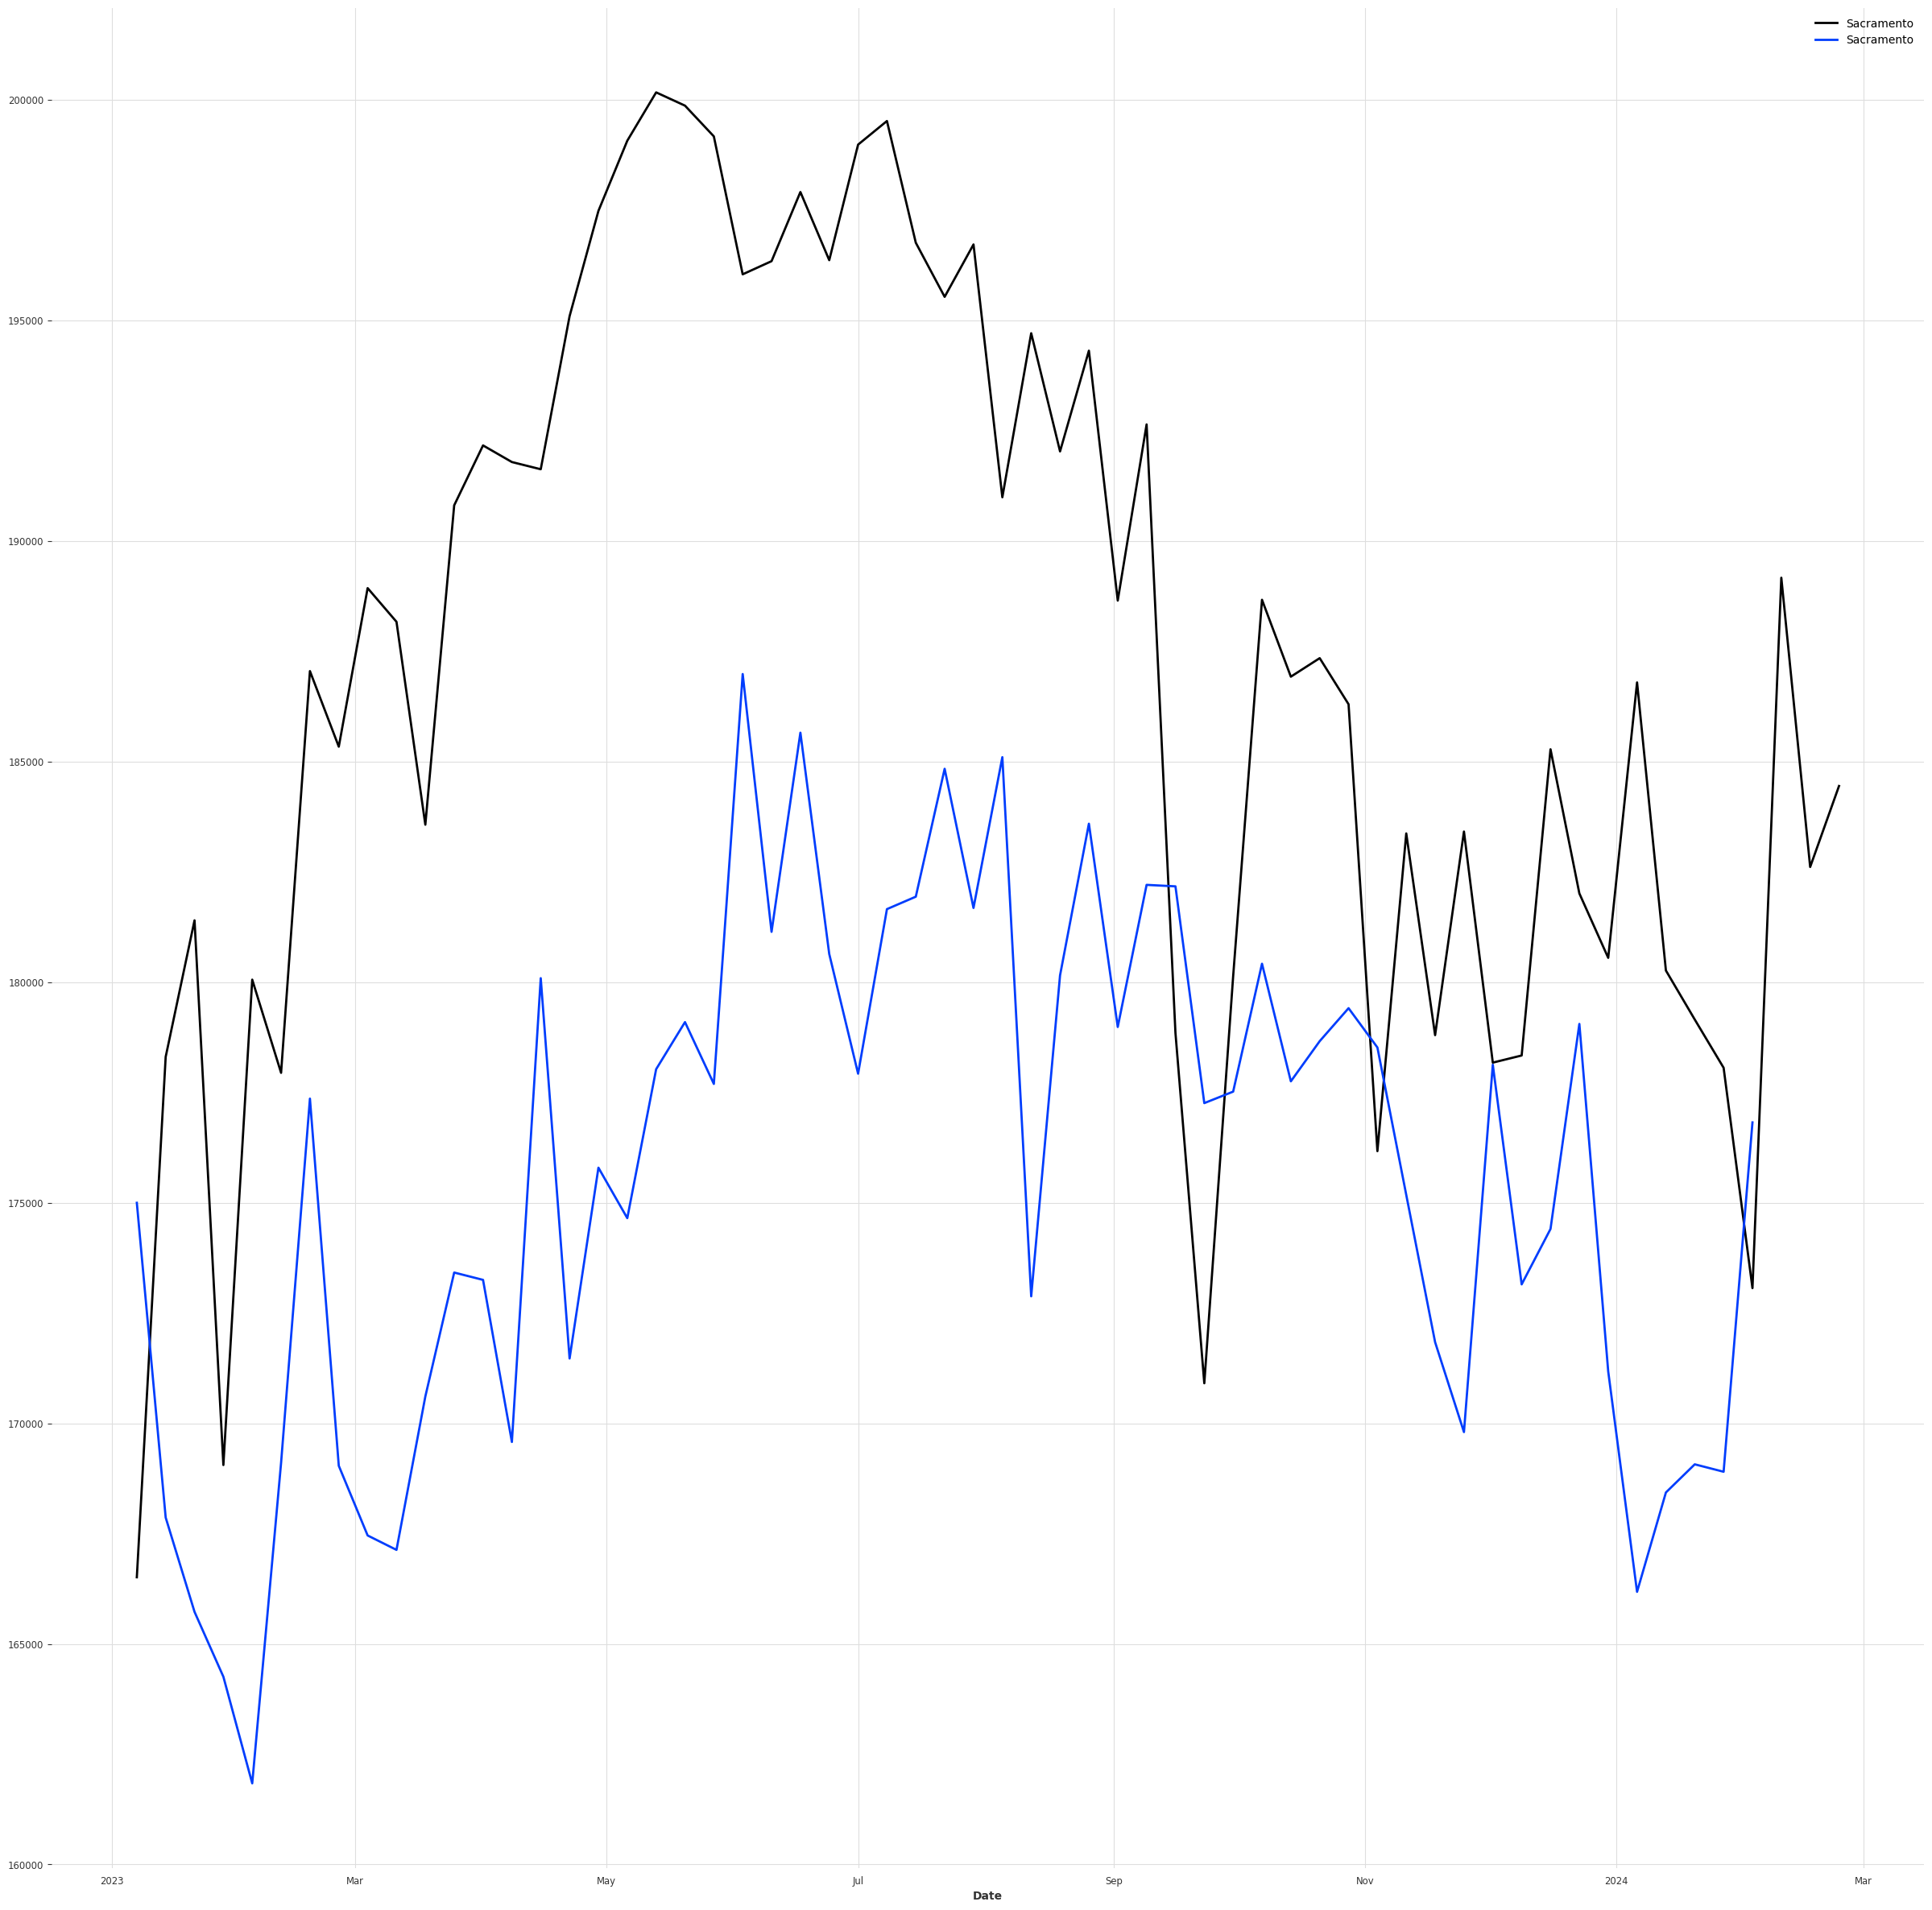

In [26]:
plt.figure(figsize=(30,30))
preds['Sacramento'].plot()
median_test['Sacramento'].plot()

<Axes: xlabel='Date'>

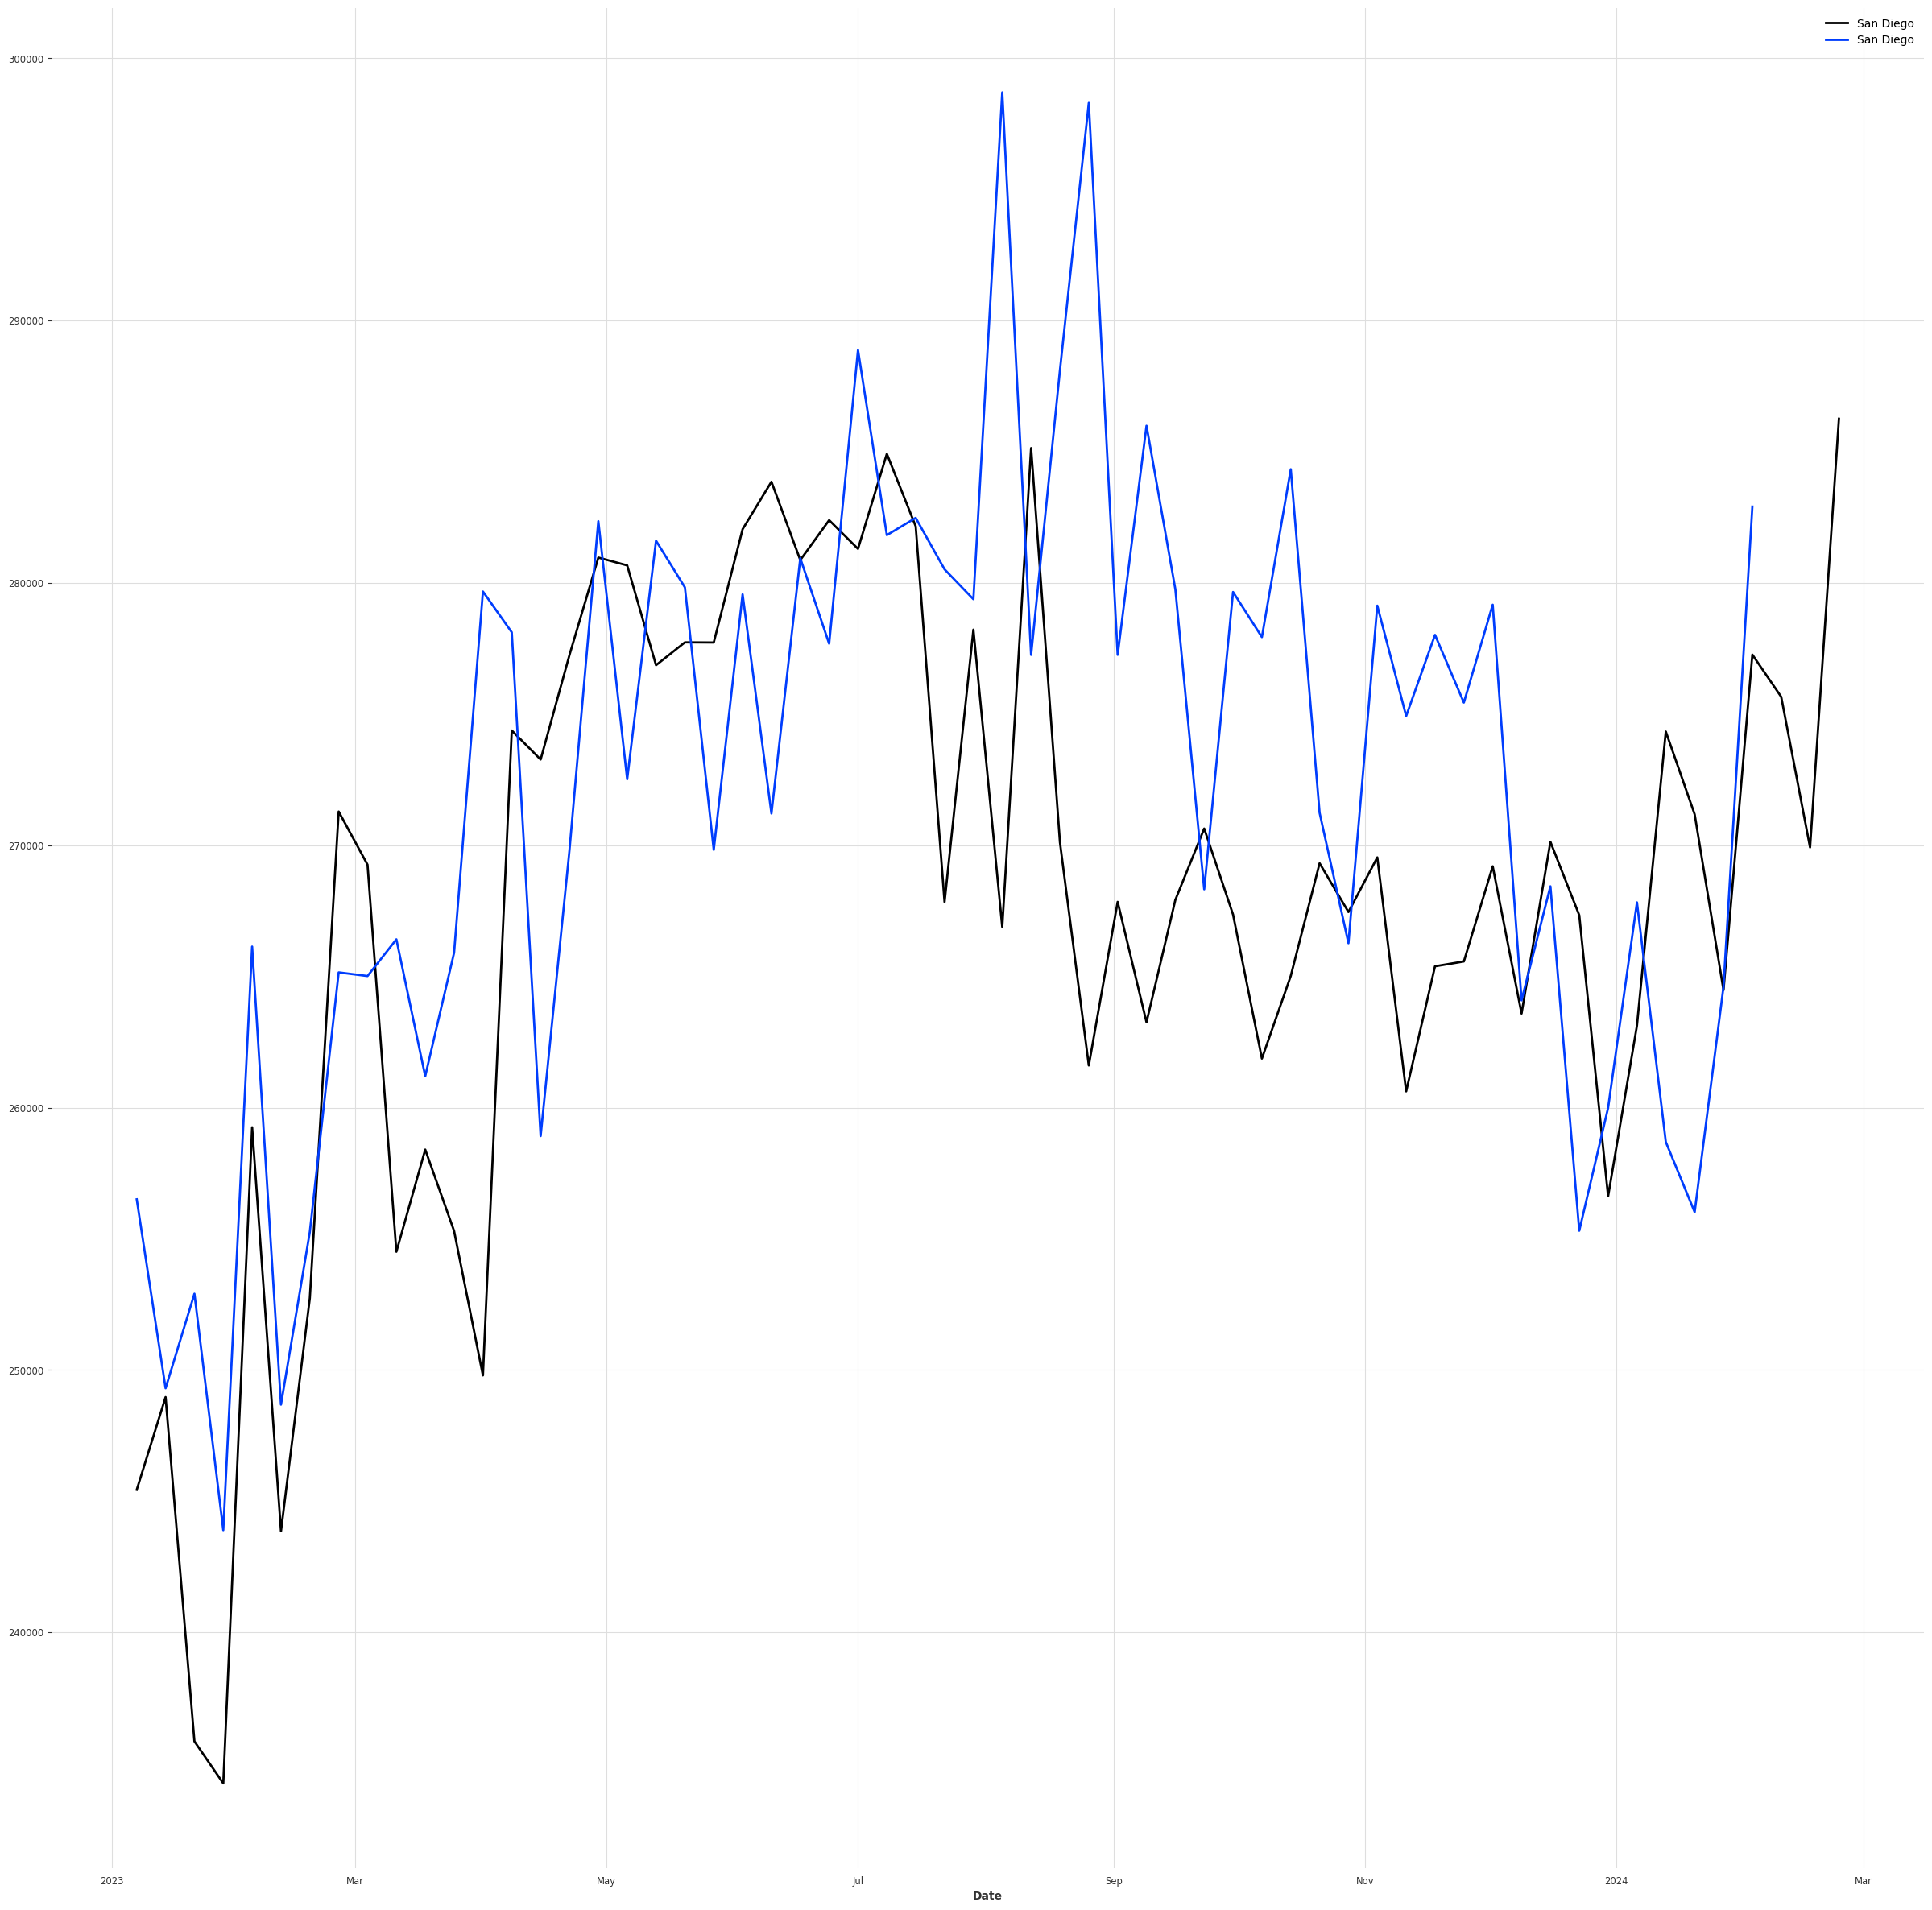

In [27]:
plt.figure(figsize=(30,30))
preds['San Diego'].plot()
median_test['San Diego'].plot()

In [28]:
finalmdl = XGBModel(lags=52,lags_past_covariates=4,output_chunk_length=60,
                  random_state=42,
                  add_encoders={'cyclic': {'past' : ['month'],'future' : ['month']},
                                'datetime_attribute' : {'past':['month','year'],'future':['month','year']}})

finalmdl.fit(Counties_median.drop_columns('CPI'),CPI)

preds = finalmdl.predict(n=60)

Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


In [29]:
median_preds = preds

<Axes: xlabel='Date'>

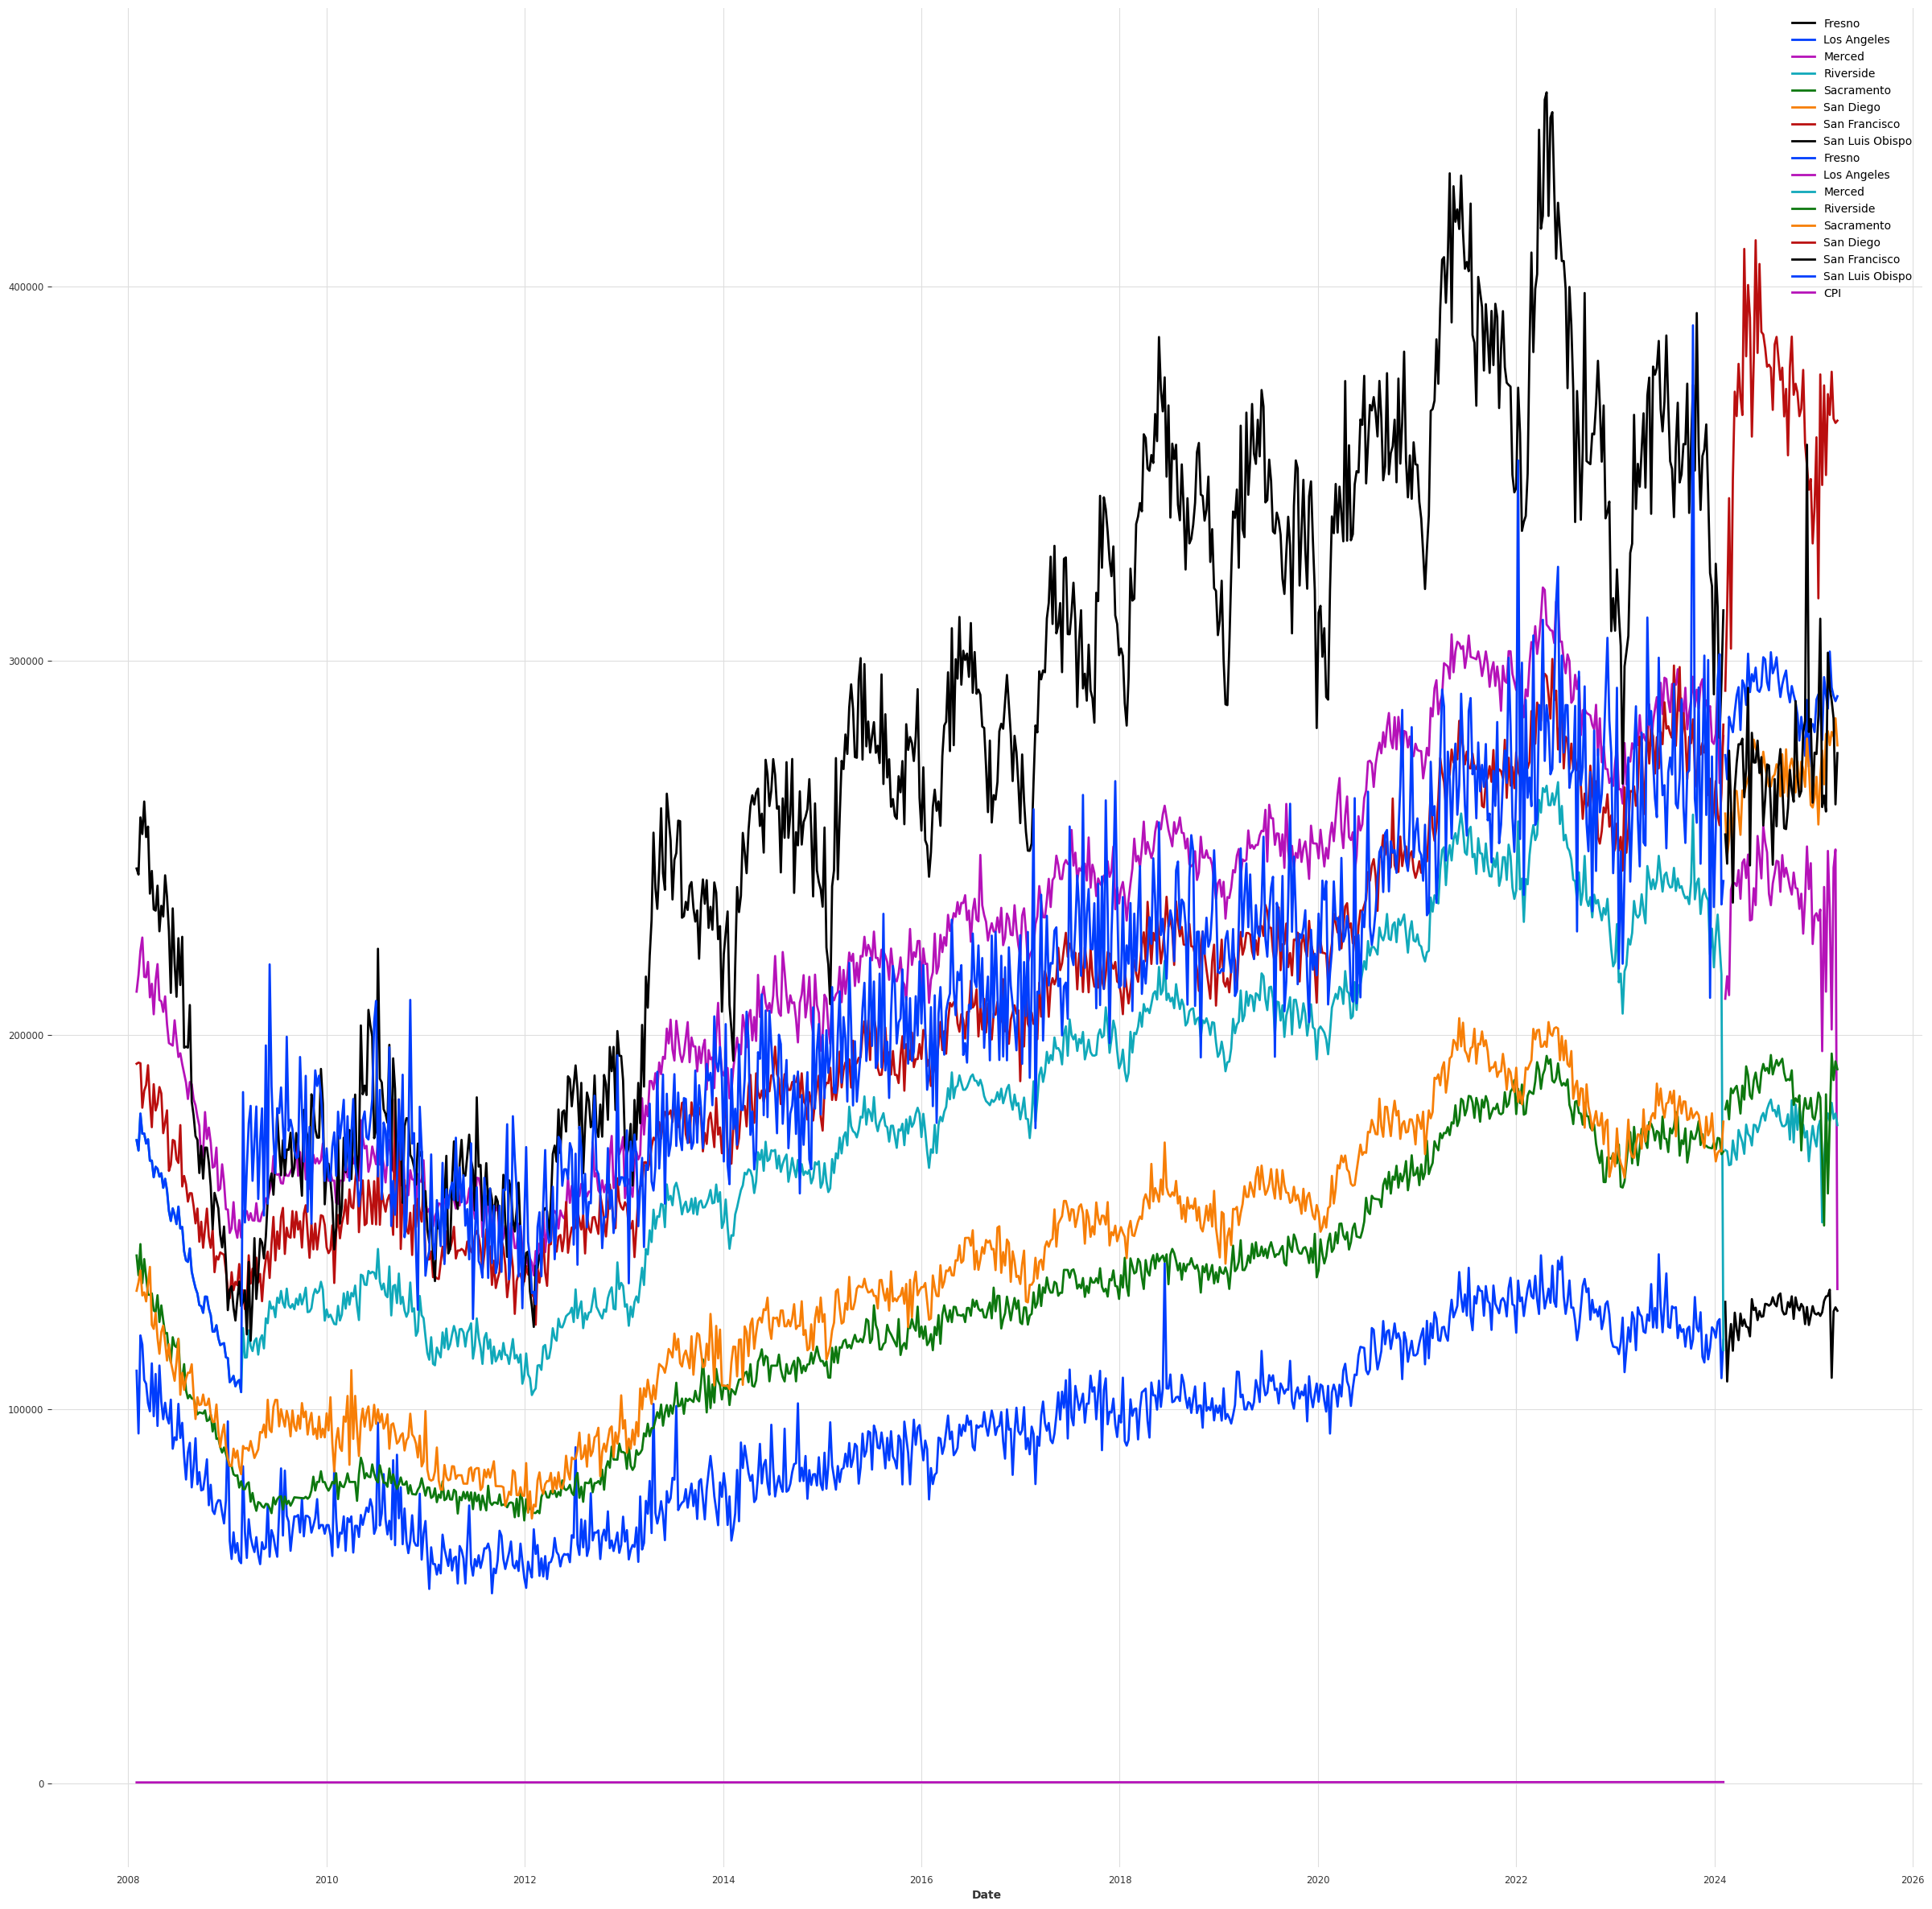

In [30]:
plt.figure(figsize=(30,30))
preds.plot()
Counties_median.plot()

<Axes: xlabel='Date'>

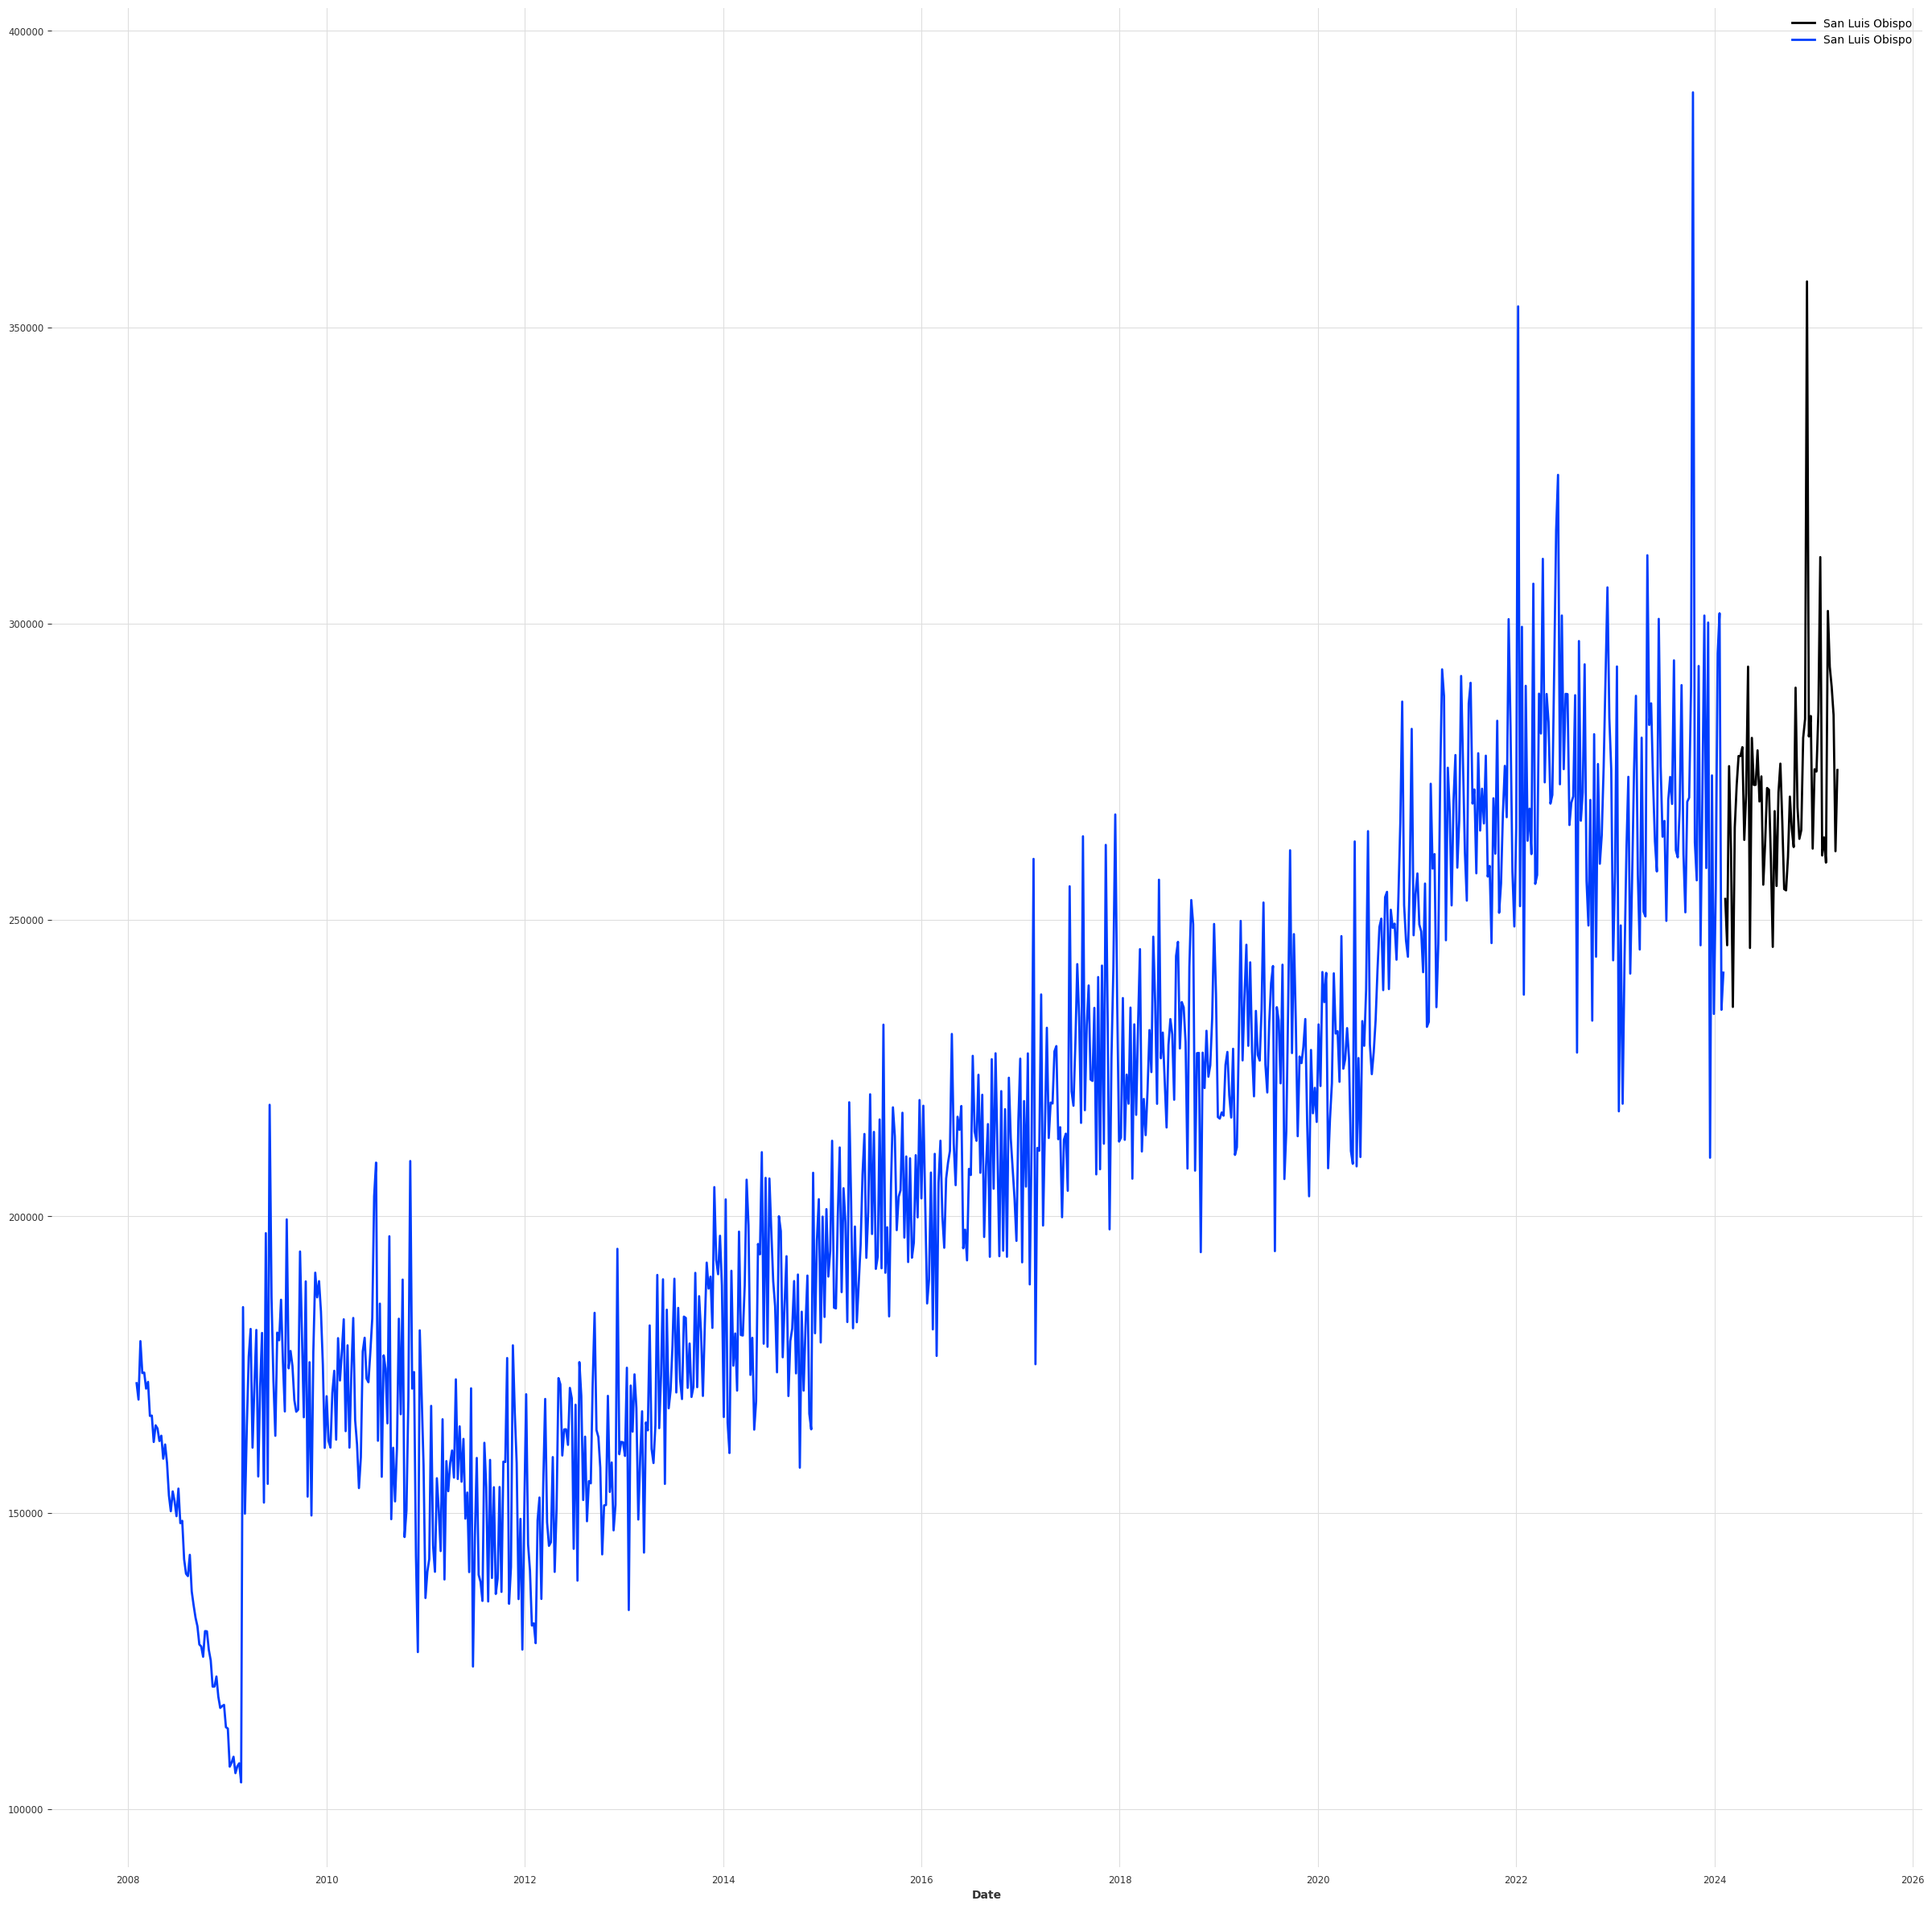

In [31]:
plt.figure(figsize=(30,30))
median_preds['San Luis Obispo'].plot()
Counties_median['San Luis Obispo'].plot()

In [32]:
xgmodel = XGBModel(lags=52,lags_past_covariates=4,output_chunk_length=60,
                  random_state=42,
                  add_encoders={'cyclic': {'past' : ['month'],'future' : ['month']},
                                'datetime_attribute' : {'past':['month','year'],'future':['month','year']}})

xgmodel.fit(value_train['San Diego'],past_covariates=median_train['CPI'])

preds = xgmodel.predict(n=60)

Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


<Axes: xlabel='Date'>

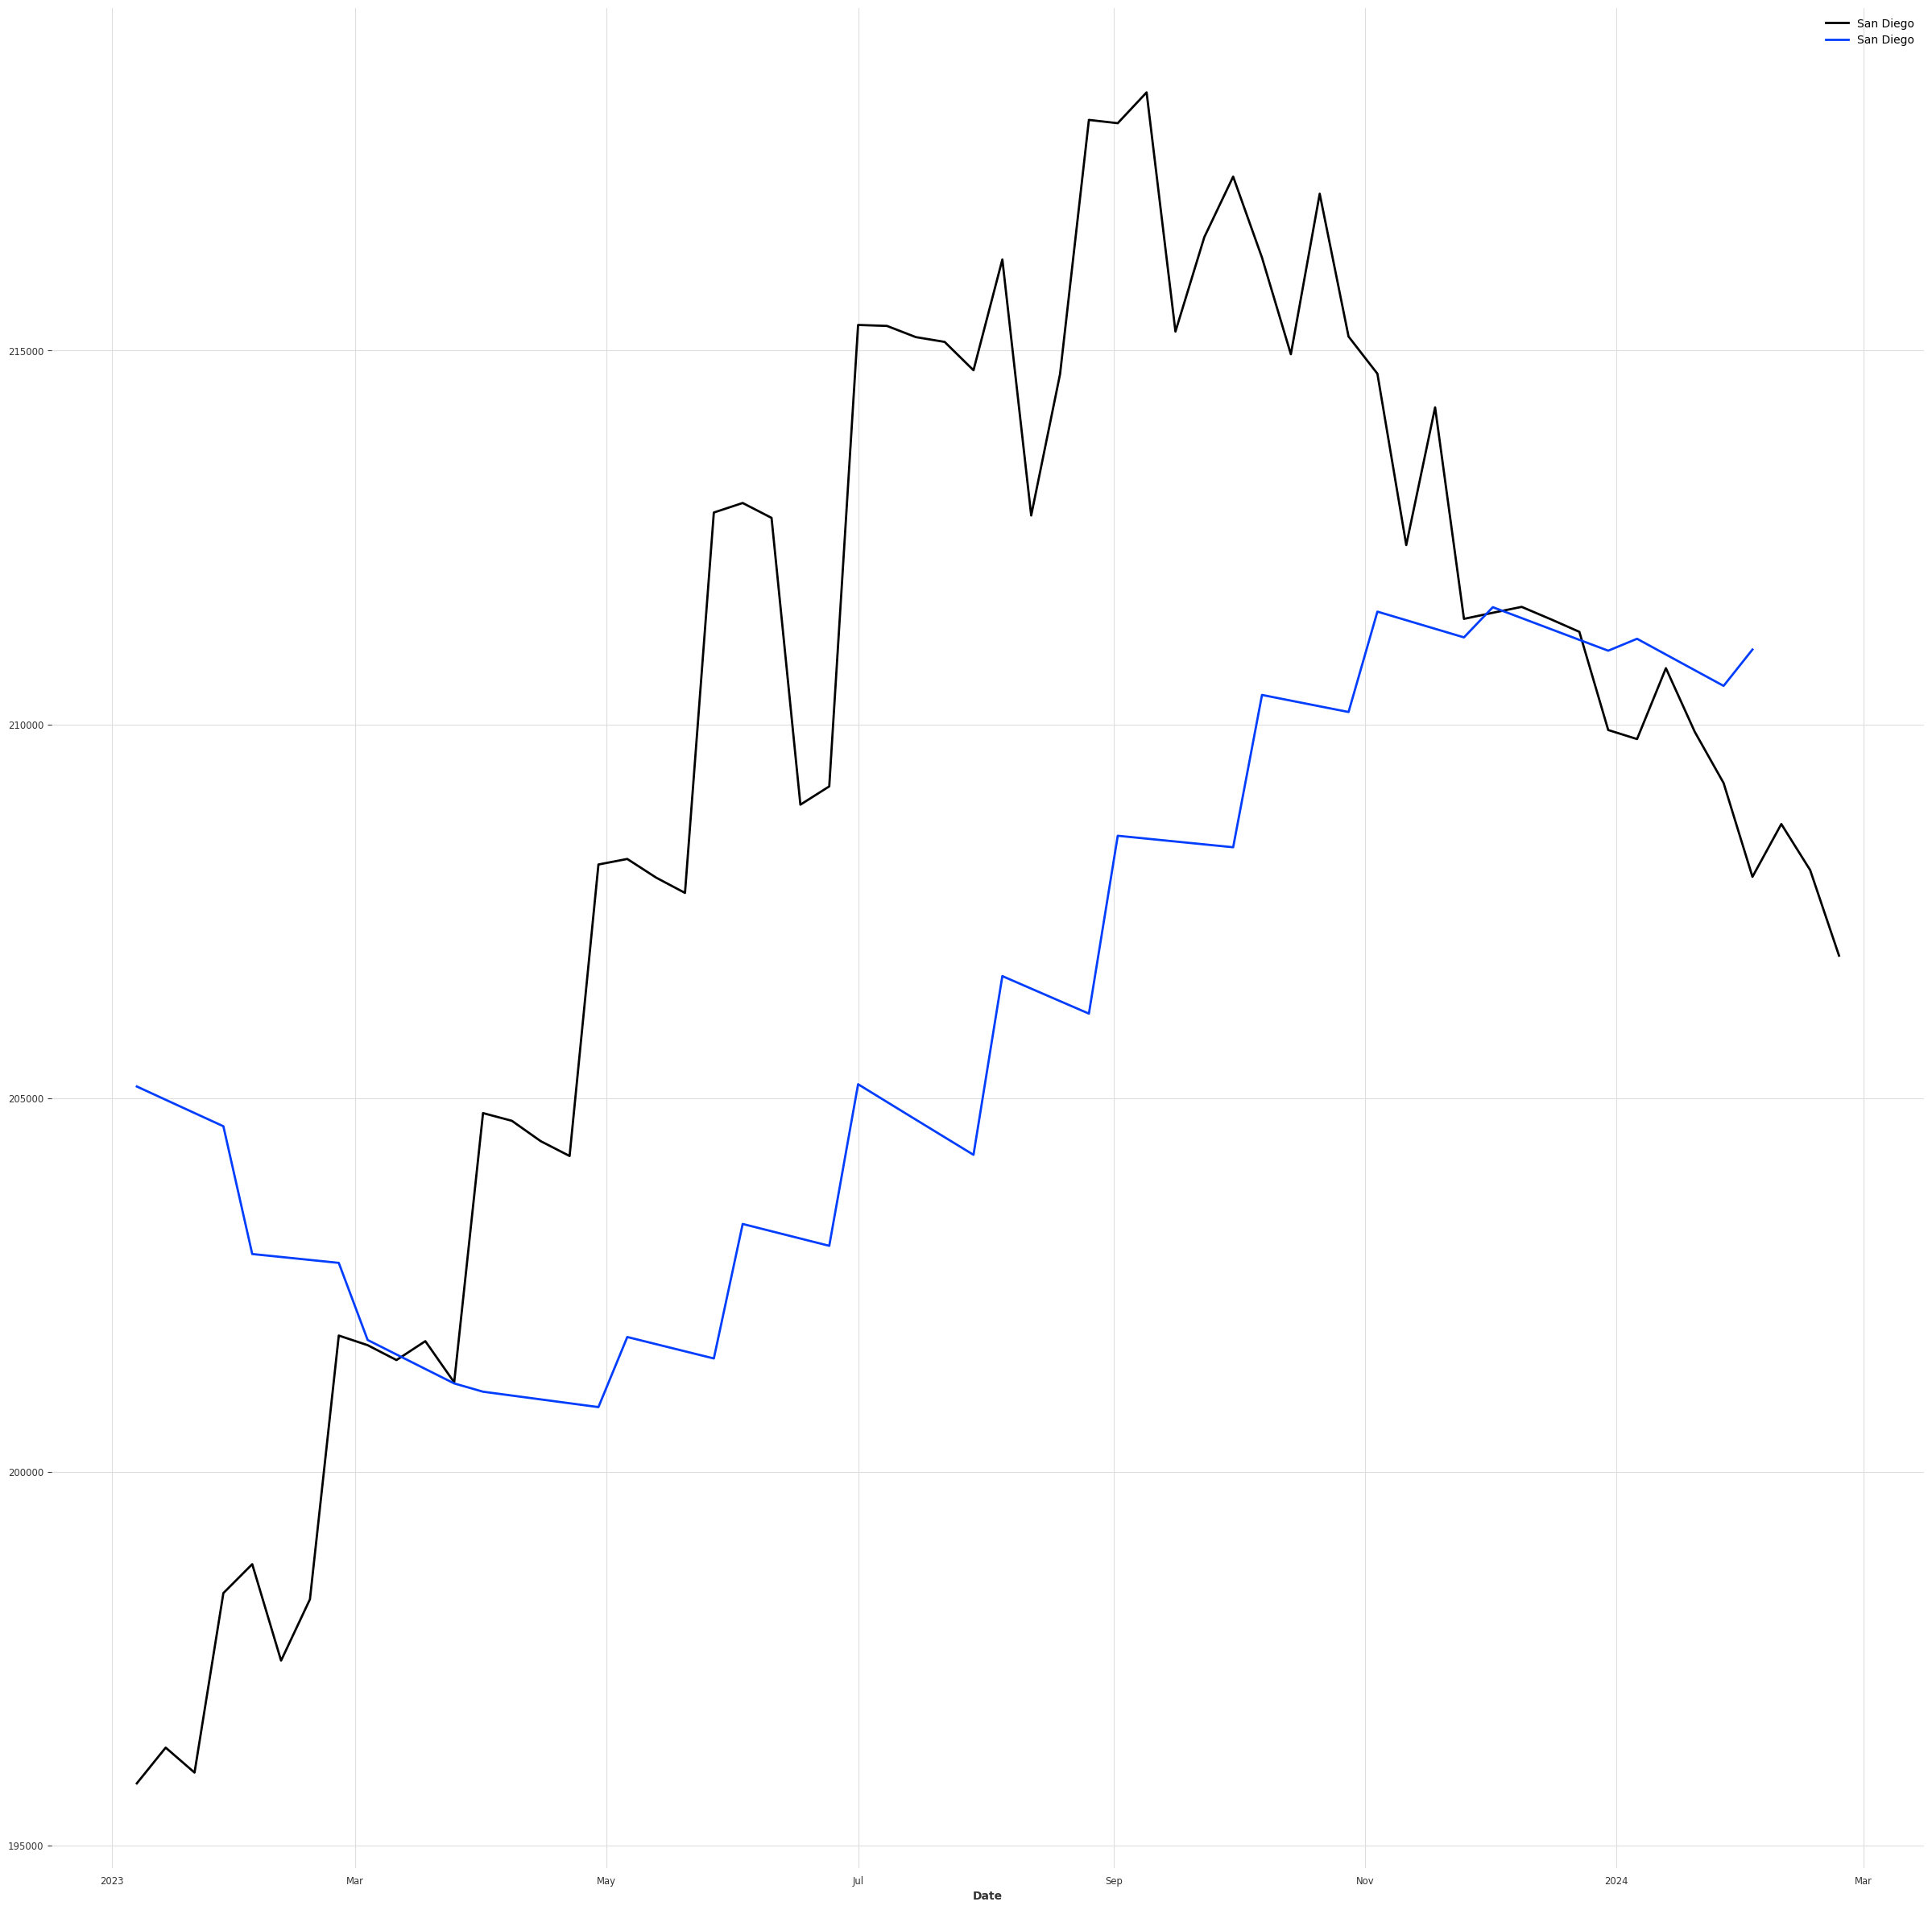

In [33]:
plt.figure(figsize=(30,30))
preds.plot()
value_test['San Diego'].plot()

In [34]:
from darts.metrics import rmse

test = [[26,4],[26,8],[26,12],[26,16],[26,20],[26,24],[52,4],[52,8],[52,12],[52,16],[52,20],
        [52,24],[60,4],[60,8],[60,12],[60,16],[60,20],[60,24]]
names = value_train.columns

results = {}
rmses = {}

for i in test:
    avg_rmse = []
    modl = XGBModel(lags=i[0],lags_past_covariates=i[1],output_chunk_length=60,
                  random_state=42,
                  add_encoders={'cyclic': {'future' : ['month']}})
    for j in names:

        modl.fit(value_train[j],past_covariates=median_train['CPI'])

        preds = modl.predict(57)

        avg_rmse.append(rmse(value_test[j],preds))

    results[str(i)] = avg_rmse

for i in results.keys():
    rmses[i] = np.mean(results[i])

rmses

Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
Specified future enc

{'[26, 4]': 12594.14782201087,
 '[26, 8]': 12608.843560805864,
 '[26, 12]': 12590.496018276232,
 '[26, 16]': 12564.256420441807,
 '[26, 20]': 12547.7416627075,
 '[26, 24]': 12561.624099816047,
 '[52, 4]': 12625.981261814024,
 '[52, 8]': 12626.29152061047,
 '[52, 12]': 12643.859889991263,
 '[52, 16]': 12598.545649163294,
 '[52, 20]': 12598.132024603357,
 '[52, 24]': 12583.03228166254,
 '[60, 4]': 12472.334767231696,
 '[60, 8]': 12487.38252427405,
 '[60, 12]': 12515.18144078509,
 '[60, 16]': 12511.316930033667,
 '[60, 20]': 12511.984540481786,
 '[60, 24]': 12475.523065419258}

In [35]:
dict(sorted(rmses.items(), key=lambda item: item[1]))

{'[60, 4]': 12472.334767231696,
 '[60, 24]': 12475.523065419258,
 '[60, 8]': 12487.38252427405,
 '[60, 16]': 12511.316930033667,
 '[60, 20]': 12511.984540481786,
 '[60, 12]': 12515.18144078509,
 '[26, 20]': 12547.7416627075,
 '[26, 24]': 12561.624099816047,
 '[26, 16]': 12564.256420441807,
 '[52, 24]': 12583.03228166254,
 '[26, 12]': 12590.496018276232,
 '[26, 4]': 12594.14782201087,
 '[52, 20]': 12598.132024603357,
 '[52, 16]': 12598.545649163294,
 '[26, 8]': 12608.843560805864,
 '[52, 4]': 12625.981261814024,
 '[52, 8]': 12626.29152061047,
 '[52, 12]': 12643.859889991263}

In [113]:
xgmodel = XGBModel(lags=60,lags_past_covariates=4,output_chunk_length=60,
                  random_state=42,
                  add_encoders={'cyclic': {'past' : ['month'],'future' : ['month']},
                                'datetime_attribute' : {'past':['month','year'],'future':['month','year']}})

xgmodel.fit(value_train['San Diego'],past_covariates=median_train['CPI'])

preds = xgmodel.predict(n=60)

Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


<Axes: xlabel='Date'>

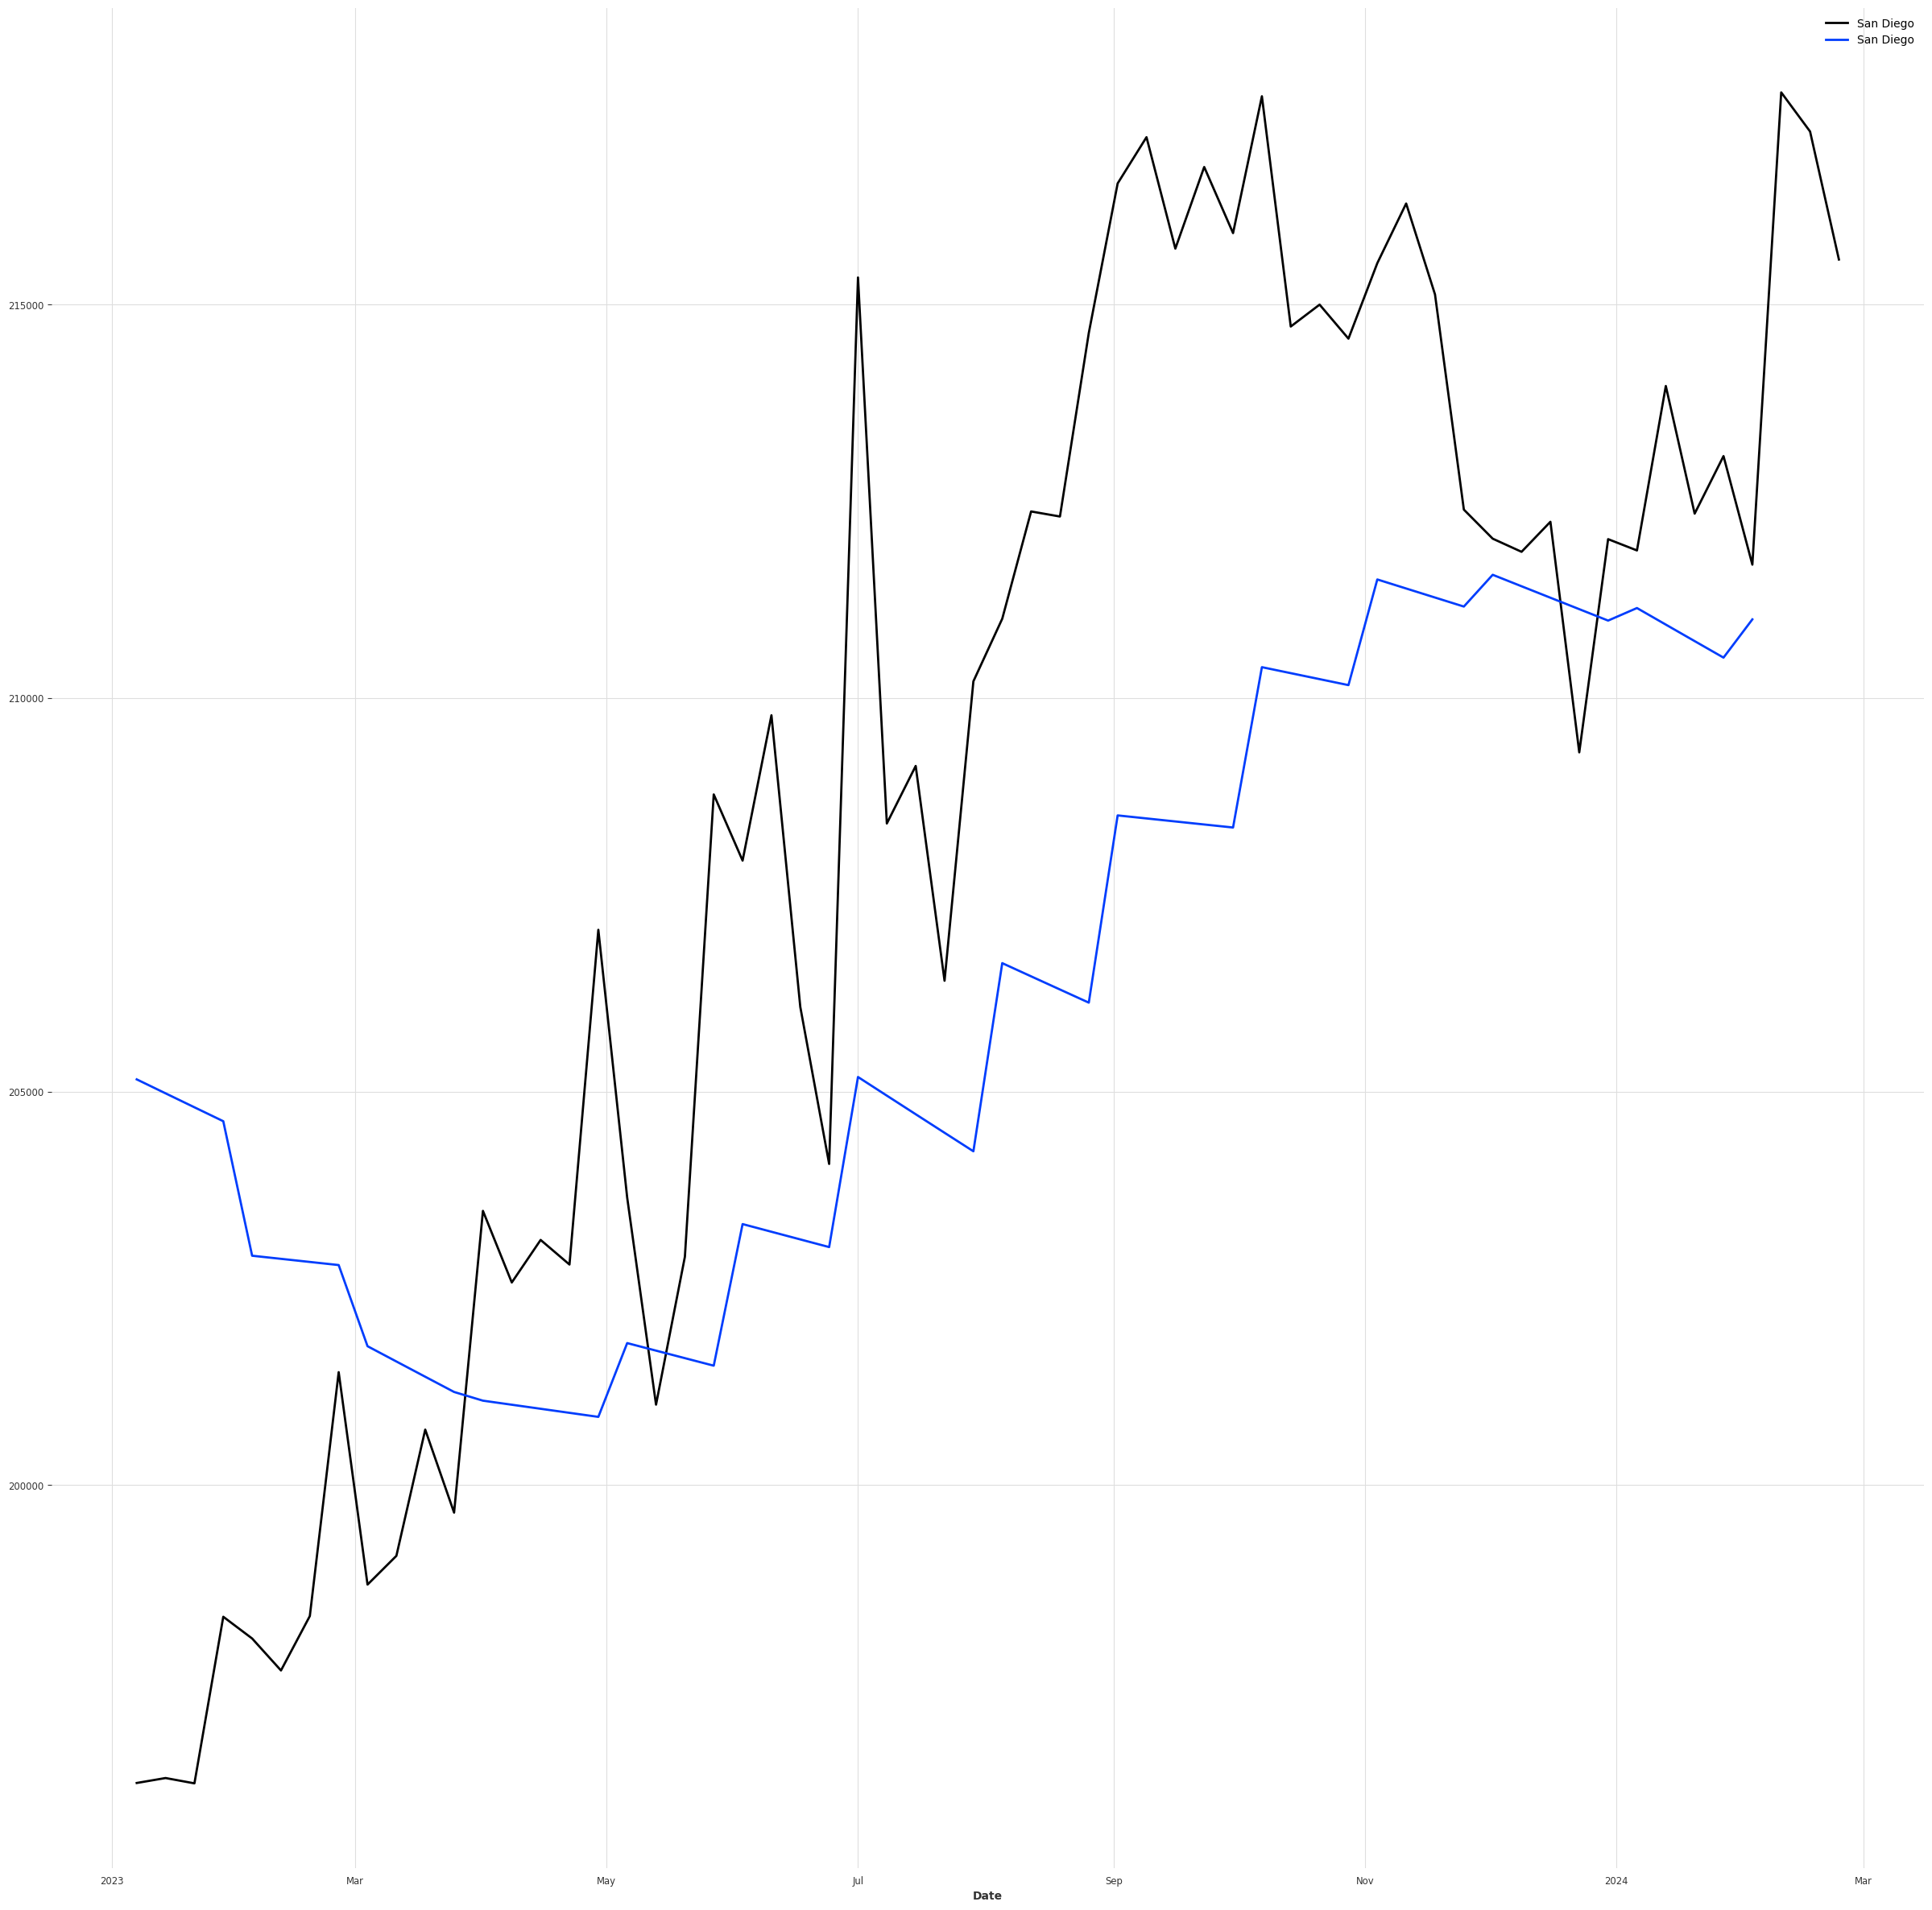

In [114]:
plt.figure(figsize=(30,30))
preds.plot()
value_test['San Diego'].plot()

In [38]:
valuemodel = XGBModel(lags=60,lags_past_covariates=4,output_chunk_length=60,
                  random_state=42,
                  add_encoders={'cyclic': {'past' : ['month'],'future' : ['month']},
                                'datetime_attribute' : {'past':['month','year'],'future':['month','year']}})

valuemodel.fit(Counties_value.drop_columns('CPI'),past_covariates=CPI)

preds = valuemodel.predict(n=60)

Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


<Axes: xlabel='Date'>

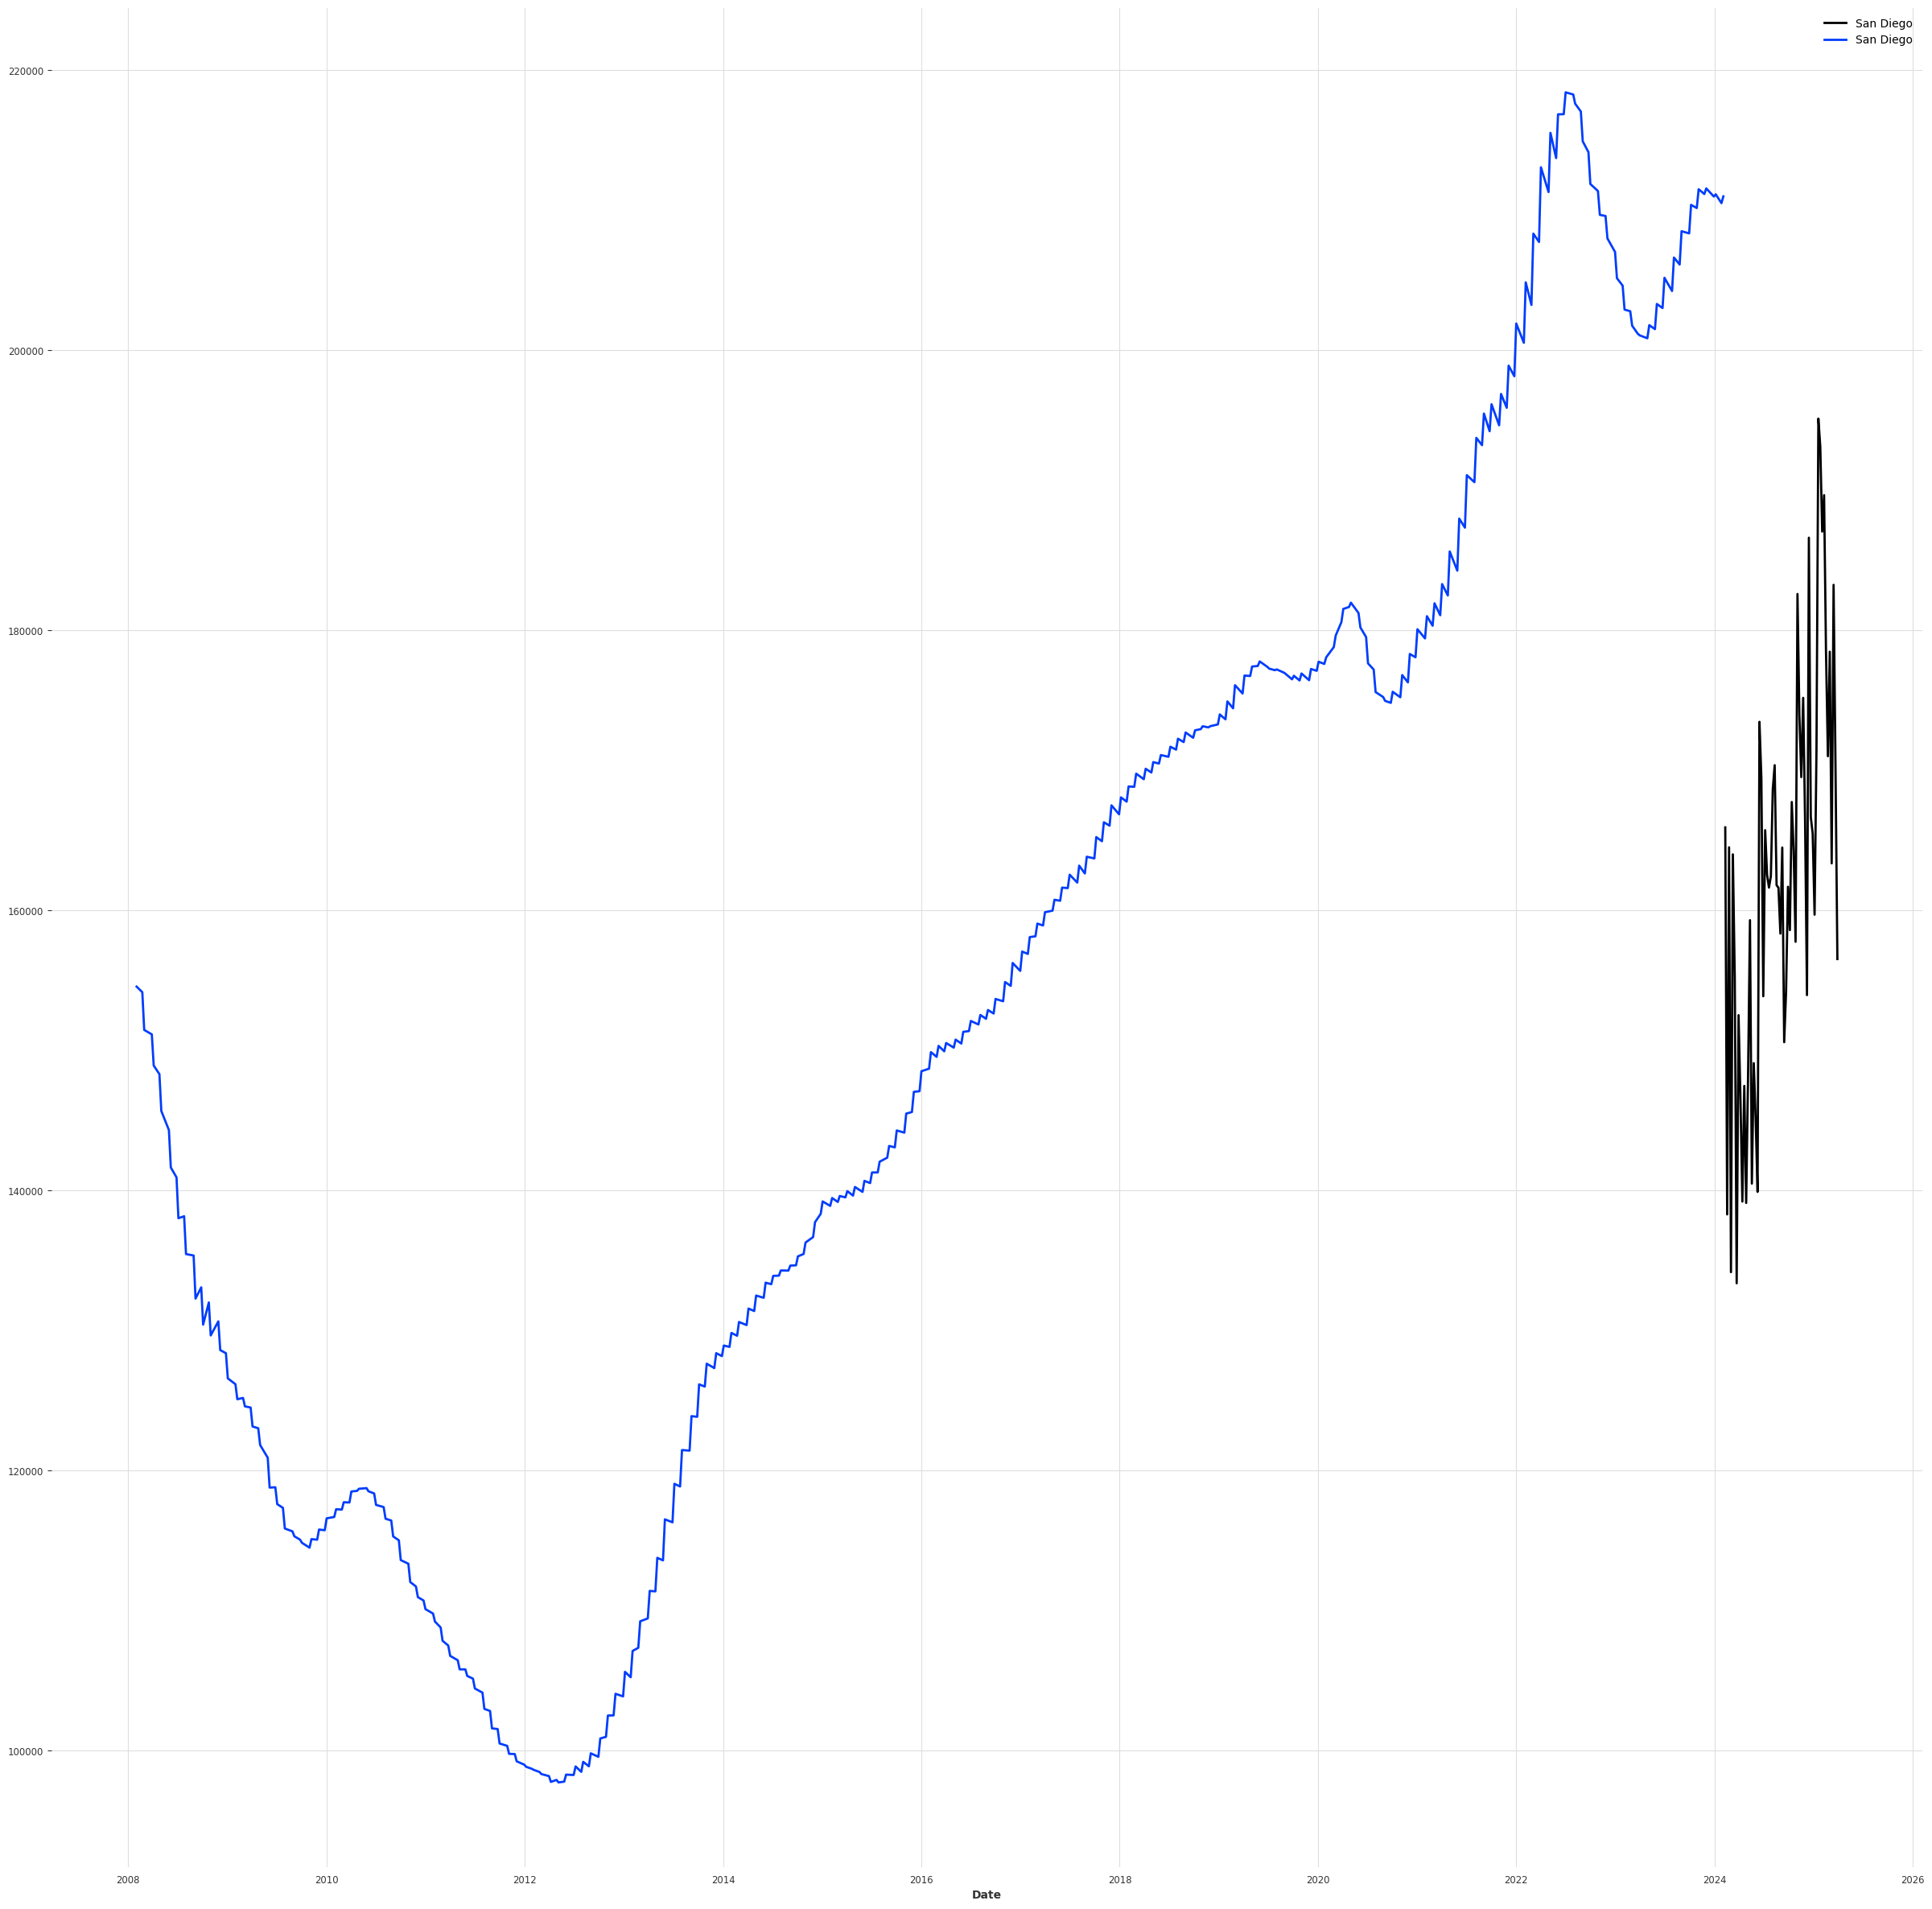

In [109]:
plt.figure(figsize=(30,30))
preds['San Diego'].plot()
Counties_value['San Diego'].plot()

In [41]:
value_preds = preds

In [136]:
from darts import TimeSeries

predicted_df = TimeSeries.pd_dataframe(median_preds).reset_index()
predicted_df_median = predicted_df

predicted_df = TimeSeries.pd_dataframe(value_preds).reset_index()
predicted_df_value = predicted_df

In [155]:
data['County'].unique()

array(['Los Angeles', 'San Francisco', 'Riverside', 'San Diego',
       'Sacramento', 'Fresno', 'San Luis Obispo', 'Merced'], dtype=object)

In [157]:
updated_Counties = []

for i in data['County'].unique():
    current_CPI = 314.175
    new_df = pd.DataFrame({'adj_median_price':predicted_df_median[i].values,
                        'adj_avg_value':predicted_df_value[i].values},
                        predicted_df_median['Date'].dt.strftime('%Y-%m-%d'))
    new_df['County'] = [i] * 60
    new_df['median_price'] = new_df['adj_median_price'] * current_CPI / 100
    new_df['avg_value'] = new_df['adj_avg_value'] * current_CPI / 100
    new_df
    testdf = data[data['County'] == i].copy()
    updated_Counties.append(pd.concat([testdf.set_index('Date'),new_df]))

updated_data = pd.concat(updated_Counties)
updated_data


County  median_price      avg_value         CPI  \
Date                                                               
2008-02-02  Los Angeles  450000.00000  415114.267851  212.713241   
2008-02-09  Los Angeles  460000.00000  415114.267851  212.896931   
2008-02-16  Los Angeles  474000.00000  415114.267851  213.080621   
2008-02-23  Los Angeles  482000.00000  415114.267851  213.264310   
2008-03-01  Los Angeles  460000.00000  409234.159417  213.448000   
...                 ...           ...            ...         ...   
2025-03-01       Merced  732394.37500  296140.812500         NaN   
2025-03-08       Merced  632844.06250  295203.812500         NaN   
2025-03-15       Merced  768708.93750  259331.984375         NaN   
2025-03-22       Merced  783995.68750  279701.812500         NaN   
2025-03-29       Merced  414920.84375  289259.093750         NaN   

            adj_median_price  adj_avg_value  
Date                                         
2008-02-02     211552.415394  195152.057841  
2008-02-09     216066.994374  194983.678644  
2008-02-16     222451.013361  194815.589756  
2008-02-23     226010.624666  194647.790425  
2008-03-01     215509.163824  191725.459792  
...                      ...            ...  
2025-03-01     233116.718750   94259.828125  
2025-03-08     201430.437500   93961.585938  
2025-03-15     244675.406250   82543.804688  
2025-03-22     249541.078125   89027.390625  
2025-03-29     132066.796875   92069.421875  

[7168 rows x 6 columns]

In [162]:
updated_data.reset_index().to_csv('final_dataset.csv', index=False)

In [169]:
start2024 = updated_data[updated_data.index == '2024-01-06']
finalpredics = updated_data[updated_data.index == '2025-03-29']
percent_change = ((finalpredics['median_price'].values - start2024['median_price'].values) / 
                  start2024['median_price'].values)*100

np.mean(percent_change)

2.621443082423273